# Experiment 2: Template Prompt Transfer with Genetic Algorithms

## Goal
Transfer prompt style from a reference image to a target model, evolving structured prompts.

## Methodology
- **Genome**: BlockGenome (subject + composition + lighting + style + quality + negative)
- **Fitness**: w1 * CLIP_score + w2 * LPIPS_similarity (to reference)
- **Reference**: High-quality image whose style/structure we want to replicate
- **Target Model**: qwen-image (Fal AI)
- **LLM Seeding**: Use Gemini to analyze reference and generate initial seeds

## Sub-experiments
- **2.1 Static Weights**: Fixed CLIP=0.5, LPIPS=0.5 throughout evolution
- **2.2 Adaptive Weights**: CLIP weight increases from 0.3 → 0.6 over generations
  - Early: Focus on structure matching (LPIPS)
  - Later: Focus on content alignment (CLIP)

---

## Cell 0: Install Dependencies

Run this cell first to ensure all required packages are installed.

In [1]:
# Install required dependencies for Experiment 2
# LPIPS is required for perceptual similarity scoring

import subprocess
import sys

def install_if_missing(package, pip_name=None):
    """Install package if not already installed."""
    pip_name = pip_name or package
    try:
        __import__(package)
        print(f"✓ {package} is already installed")
    except ImportError:
        print(f"Installing {pip_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", pip_name, "-q"])
        print(f"✓ {pip_name} installed successfully")

# Install lpips (Learned Perceptual Image Patch Similarity)
install_if_missing("lpips")

# Other dependencies that should already be installed
install_if_missing("transformers")
install_if_missing("torch")
install_if_missing("torchvision")

print("\nAll dependencies ready!")

✓ lpips is already installed
✓ transformers is already installed
✓ torch is already installed
✓ torchvision is already installed

All dependencies ready!


In [2]:
# Standard library imports
import sys
import os
import json
import random
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional

# Add parent directory to path for src imports
sys.path.insert(0, '..')

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
import scipy.stats as stats

# Project imports - Block-based genome and evolution (v2)
from src.genome_v2 import BlockGenome, BlockGenomeFactory
from src.evolution_v2 import BlockGeneticOperators, BlockEvolutionEngine
from src.fitness_v2 import TemplateFitnessEvaluator, AdaptiveTemplateFitnessEvaluator
from src.models import get_model
from src.llm_prompt_generator import get_prompt_generator, GeminiPromptGenerator, DummyPromptGenerator
from src.vocabulary_manager import VocabularyManager
from src.utils import (
    create_block_vocabularies,
    save_json,
    Logger
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Configure matplotlib for publication-quality plots
plt.rcParams.update({
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

# Enable inline plotting
%matplotlib inline

print("Environment setup complete.")
print(f"Random seed: {RANDOM_SEED}")
print(f"Working directory: {os.getcwd()}")

Environment setup complete.
Random seed: 42
Working directory: /Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/experiments


## Cell 2: Configuration

In [3]:
# =============================================================================
# EXPERIMENT PARAMETERS (ENHANCED)
# =============================================================================

# Subject transfer: User's desired subject (different from reference)
USER_SUBJECT = "a professional product photo of a sport car"

# Evolution parameters - INCREASED for better results
POPULATION_SIZE = 20
MAX_GENERATIONS = 150 
ELITE_SIZE = 2
MUTATION_RATE = 0.5  # Slightly increased
ADD_PROBABILITY = 0.35
REMOVE_PROBABILITY = 0.2

# Vocabulary Manager parameters
USE_VOCABULARY_MANAGER = True  # Enable LLM-based adaptive vocabulary
VOCAB_INITIAL_SIZE = 1000  # Target size for initial vocabulary
VOCAB_EXPANSION_SIZE = 50  # New modifiers to add per expansion
VOCAB_PRUNE_THRESHOLD = 20  # Generations before pruning unused modifiers
VOCAB_EXPANSION_INTERVAL = 5  # Expand vocabulary every N generations
VOCAB_PRUNE_INTERVAL = 10  # Prune vocabulary every N generations

# Genome constraints - EXPANDED search space
MAX_ITEMS_PER_BLOCK = 5  # Increased from 3 to 5

# =============================================================================
# FITNESS WEIGHTS
# =============================================================================

# Static weights (Experiment 2.1)
STATIC_CLIP_WEIGHT = 0.5   # Content alignment with user subject
STATIC_LPIPS_WEIGHT = 0.5  # Structure similarity to reference

# Adaptive weights (Experiment 2.2)
# Strategy: Start with structure matching, shift to content alignment
INITIAL_CLIP_WEIGHT = 0.3  # Early: prioritize LPIPS (structure)
FINAL_CLIP_WEIGHT = 0.6    # Late: prioritize CLIP (content)

# =============================================================================
# MODEL SETTINGS
# =============================================================================

# Reference model: qwen-image (for generating reference template)
REFERENCE_MODEL_NAME = "qwen-image"  # High-quality reference generation

# Target model: flux-schnell (for evolution - more cost-effective)
MODEL_NAME = "flux-schnell"  # Fast and cost-effective for evolution

IMAGE_SIZE = "landscape_4_3"

# Model-specific parameters
# Qwen-image parameters
QWEN_INFERENCE_STEPS = 30
QWEN_GUIDANCE_SCALE = 3.5

# Flux-schnell parameters (max 12 steps, no guidance_scale)
FLUX_INFERENCE_STEPS = 4  # Flux-schnell max is 12, using 4 for speed
FLUX_GUIDANCE_SCALE = None  # Flux-schnell doesn't support guidance_scale

# Use appropriate parameters based on model
NUM_INFERENCE_STEPS = FLUX_INFERENCE_STEPS if MODEL_NAME == "flux-schnell" else QWEN_INFERENCE_STEPS
GUIDANCE_SCALE = FLUX_GUIDANCE_SCALE if MODEL_NAME == "flux-schnell" else QWEN_GUIDANCE_SCALE

GENERATION_SEED = 42  # Fixed seed for reproducible image generation

# =============================================================================
# LLM SETTINGS
# =============================================================================

USE_LLM_SEEDING = True  # Set to False to use random seeding (no Gemini required)

# =============================================================================
# OUTPUT SETTINGS
# =============================================================================

OUTPUT_DIR = Path("../data/results/experiment_2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
SAVE_EVERY_N_GENERATIONS = 5  # Save checkpoints every N generations
SAVE_ALL_IMAGES = True  # NEW: Save all generated images

# =============================================================================
# RESULTS TRACKING
# =============================================================================

# Global array to store all results
ALL_RESULTS = []

# Print configuration summary
print("=" * 60)
print("EXPERIMENT 2 CONFIGURATION (ENHANCED)")
print("=" * 60)
print(f"\nUser Subject: {USER_SUBJECT}")
print(f"\nEvolution Parameters:")
print(f"  Population Size: {POPULATION_SIZE}")
print(f"  Max Generations: {MAX_GENERATIONS}")
print(f"  Elite Size: {ELITE_SIZE}")
print(f"  Mutation Rate: {MUTATION_RATE}")
print(f"  Max Items per Block: {MAX_ITEMS_PER_BLOCK}")
print(f"\nStatic Weights (Exp 2.1):")
print(f"  CLIP: {STATIC_CLIP_WEIGHT}, LPIPS: {STATIC_LPIPS_WEIGHT}")
print(f"\nAdaptive Weights (Exp 2.2):")
print(f"  CLIP: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"\nReference Model: {REFERENCE_MODEL_NAME} (for template generation)")
print(f"Target Model: {MODEL_NAME} (for evolution)")
print(f"LLM Seeding: {'Enabled (Gemini)' if USE_LLM_SEEDING else 'Disabled (Random)'}")
print(f"Save All Images: {SAVE_ALL_IMAGES}")
print(f"Output Directory: {OUTPUT_DIR}")
print("=" * 60)

EXPERIMENT 2 CONFIGURATION (ENHANCED)

User Subject: a professional product photo of a sport car

Evolution Parameters:
  Population Size: 20
  Max Generations: 150
  Elite Size: 2
  Mutation Rate: 0.5
  Max Items per Block: 5

Static Weights (Exp 2.1):
  CLIP: 0.5, LPIPS: 0.5

Adaptive Weights (Exp 2.2):
  CLIP: 0.3 -> 0.6

Reference Model: qwen-image (for template generation)
Target Model: flux-schnell (for evolution)
LLM Seeding: Enabled (Gemini)
Save All Images: True
Output Directory: ../data/results/experiment_2


## Cell 3: Load Reference Image

Generating reference image using qwen-image...
Reference prompt: Professional product photo of a sport car on a showroom floor, bright studio lighting with soft shadows, clean white background, ultra‑realistic, 8k, sharp focus, high detail, minimal reflections
Reference image saved to: ../data/results/experiment_2/reference_image.jpg


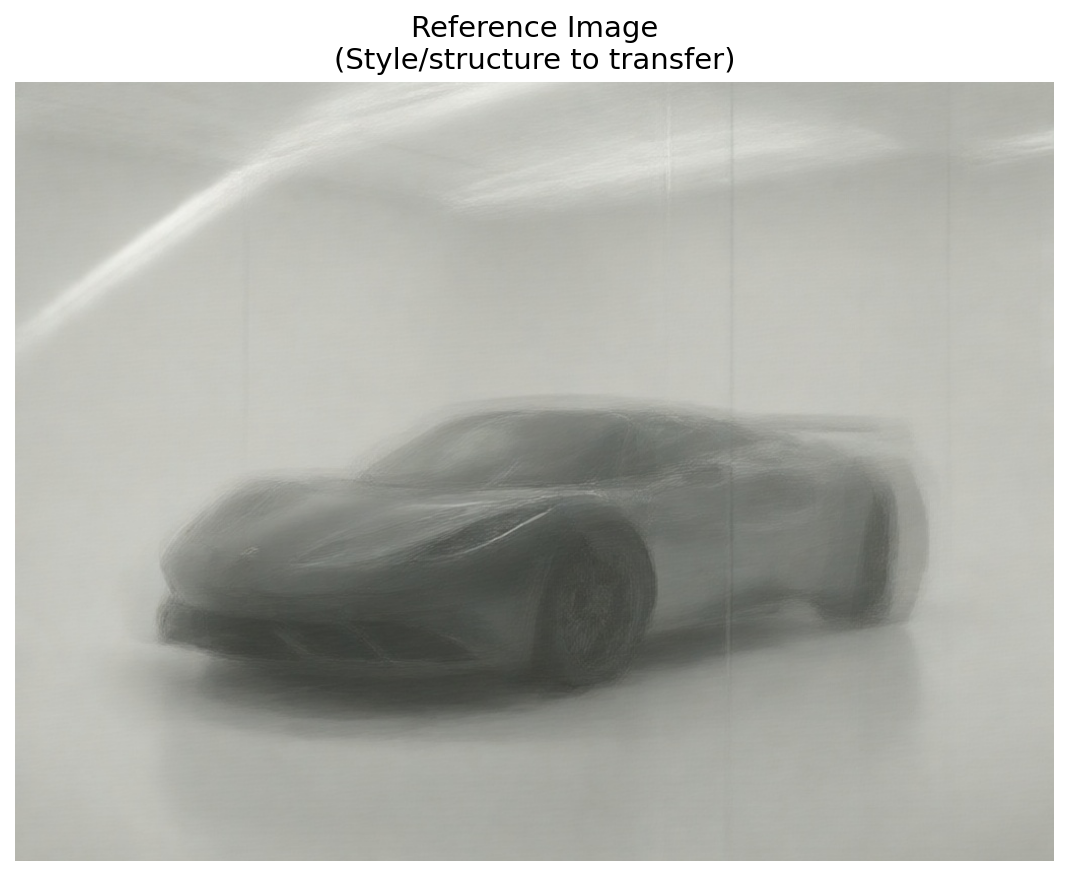


Reference image size: (1024, 768)
Target subject: a professional product photo of a sport car

Goal: Generate images of the target subject with the style/structure of the reference.


In [4]:
# =============================================================================
# LOAD REFERENCE IMAGE
# =============================================================================
# The reference image defines the style/structure we want to transfer
# to our target subject (USER_SUBJECT)

# Option 1: Load from file
REFERENCE_IMAGE_PATH = "../data/reference_images/product_reference.jpg"

# Option 2: Generate a reference image using qwen-image
GENERATE_REFERENCE = True  # Set to False to load from file
REFERENCE_PROMPT = "Professional product photo of a sport car on a showroom floor, bright studio lighting with soft shadows, clean white background, ultra‑realistic, 8k, sharp focus, high detail, minimal reflections"

if GENERATE_REFERENCE:
    print("Generating reference image using qwen-image...")
    print(f"Reference prompt: {REFERENCE_PROMPT}")
    
    # Use qwen-image for reference generation
    reference_model = get_model("qwen-image")
    
    reference_image, ref_metadata = reference_model.generate(
        prompt=REFERENCE_PROMPT,
        image_size=IMAGE_SIZE,
        num_inference_steps=4,
        seed=GENERATION_SEED
    )
    
    # Save reference image
    ref_save_path = OUTPUT_DIR / "reference_image.jpg"
    reference_image.save(ref_save_path)
    print(f"Reference image saved to: {ref_save_path}")
    
else:
    print(f"Loading reference image from: {REFERENCE_IMAGE_PATH}")
    if not Path(REFERENCE_IMAGE_PATH).exists():
        raise FileNotFoundError(f"Reference image not found: {REFERENCE_IMAGE_PATH}")
    reference_image = Image.open(REFERENCE_IMAGE_PATH).convert('RGB')
    print(f"Reference image loaded: {reference_image.size}")

# Display reference image
fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(reference_image)
ax.set_title(f"Reference Image\n(Style/structure to transfer)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "reference_display.png")
plt.show()

print(f"\nReference image size: {reference_image.size}")
print(f"Target subject: {USER_SUBJECT}")
print("\nGoal: Generate images of the target subject with the style/structure of the reference.")

## Cell 4: Initialize Components

In [5]:
# =============================================================================
# INITIALIZE IMAGE GENERATION MODEL
# =============================================================================
print("Initializing image generation model...")
model = get_model(MODEL_NAME)
print(f"  Model: {MODEL_NAME} initialized")

# =============================================================================
# CREATE BLOCK VOCABULARIES
# =============================================================================
print("\nCreating block vocabularies...")

# Initialize VocabularyManager if enabled
vocab_manager = None
if USE_VOCABULARY_MANAGER:
    print("\nInitializing VocabularyManager with LLM...")
    vocab_manager = VocabularyManager(
        use_llm=True,
        initial_size=VOCAB_INITIAL_SIZE,
        expansion_size=VOCAB_EXPANSION_SIZE,
        prune_threshold=VOCAB_PRUNE_THRESHOLD
    )
    
    # Initialize vocabulary with domain description and reference image
    domain_description = f"template-based image generation for: {USER_SUBJECT}"
    block_vocabularies = vocab_manager.initialize_vocabulary(
        reference_image=reference_image,
        domain_description=domain_description
    )
    
    print("\n  LLM-generated vocabulary:")
    print(f"  Synonym mappings: {len(vocab_manager.synonym_map)}")
else:
    # Fallback to static vocabulary
    block_vocabularies = create_block_vocabularies()
    print("\n  Static vocabulary:")

print("\nVocabulary sizes:")
for block_name, vocab in block_vocabularies.items():
    print(f"  {block_name}: {len(vocab)} terms")

# =============================================================================
# INITIALIZE LLM PROMPT GENERATOR
# =============================================================================
print("\nInitializing prompt generator...")
prompt_generator = get_prompt_generator(use_llm=USE_LLM_SEEDING)

# =============================================================================
# GENERATE LLM SEEDS (if enabled)
# =============================================================================
print("\nGenerating LLM seeds from reference image...")
llm_seeds = prompt_generator.generate_seed_prompts(
    reference=reference_image,
    user_subject=USER_SUBJECT,
    population_size=POPULATION_SIZE
)

print(f"Generated {len(llm_seeds)} seed prompts")
print("\nSample seed prompt:")
if llm_seeds:
    sample_seed = llm_seeds[0]
    for block_name, values in sample_seed.items():
        print(f"  {block_name}: {values}")

# =============================================================================
# CREATE GENOME FACTORY
# =============================================================================
print("\nCreating block genome factory...")
factory = BlockGenomeFactory(
    block_vocabularies=block_vocabularies,
    max_per_block=MAX_ITEMS_PER_BLOCK
)
print(f"  Max items per block: {MAX_ITEMS_PER_BLOCK}")

# =============================================================================
# CREATE GENETIC OPERATORS
# =============================================================================
print("\nCreating genetic operators...")
operators = BlockGeneticOperators(
    factory=factory,
    vocabulary_manager=vocab_manager,  # Enable synonym-aware mutation
    mutation_rate=MUTATION_RATE,
    add_probability=ADD_PROBABILITY,
    remove_probability=REMOVE_PROBABILITY
)
print(f"  Mutation rate: {MUTATION_RATE}")

# =============================================================================
# CREATE EVOLUTION ENGINE
# =============================================================================
print("\nCreating evolution engine...")
engine = BlockEvolutionEngine(
    factory=factory,
    operators=operators,
    population_size=POPULATION_SIZE,
    elite_size=ELITE_SIZE,
    selection_method="tournament",
    use_crossover=True  # Enable block crossover
)
print(f"  Population size: {POPULATION_SIZE}")
print(f"  Elite size: {ELITE_SIZE}")
print(f"  Crossover: Enabled")

# =============================================================================
# CREATE FITNESS EVALUATORS
# =============================================================================
print("\nCreating fitness evaluators...")

# Static fitness evaluator (Experiment 2.1)
static_evaluator = TemplateFitnessEvaluator(
    reference_image=reference_image,
    clip_weight=STATIC_CLIP_WEIGHT,
    lpips_weight=STATIC_LPIPS_WEIGHT
)
print(f"  Static Evaluator: CLIP={STATIC_CLIP_WEIGHT}, LPIPS={STATIC_LPIPS_WEIGHT}")

# Adaptive fitness evaluator (Experiment 2.2)
adaptive_evaluator = AdaptiveTemplateFitnessEvaluator(
    reference_image=reference_image,
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)
print(f"  Adaptive Evaluator: CLIP {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")

# =============================================================================
# INITIALIZE LOGGER
# =============================================================================
logger = Logger(log_dir=str(OUTPUT_DIR / "logs"), name="experiment_2")
logger.info("Experiment 2 components initialized")

print("\n" + "=" * 60)
print("ALL COMPONENTS INITIALIZED SUCCESSFULLY")
print("=" * 60)

Initializing image generation model...
  Model: flux-schnell initialized

Creating block vocabularies...

Initializing VocabularyManager with LLM...


/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


VocabularyManager: Initialized Gemini (project: hubx-ml-playground)

INITIALIZING VOCABULARY
Target size: 1000 modifiers
Domain: template-based image generation for: a professional product photo of a sport car
LLM enabled: True
Analyzing reference image...

INITIAL VOCABULARY:
  composition :  206 modifiers
  lighting    :  206 modifiers
  style       :  220 modifiers
  quality     :  221 modifiers
  negative    :  343 modifiers
  TOTAL       : 1196 modifiers
  Synonym mappings: 68


  LLM-generated vocabulary:
  Synonym mappings: 68

Vocabulary sizes:
  composition: 206 terms
  lighting: 206 terms
  style: 220 terms
  quality: 221 terms
  negative: 343 terms

Initializing prompt generator...
Initialized Gemini (gemini-2.0-flash-exp) on project hubx-ml-playground

Generating LLM seeds from reference image...


/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/vertexai/generative_models/_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


Generated 20 seed prompts

Sample seed prompt:
  composition: ['wide angle', 'centered', 'studio shot']
  lighting: ['soft diffused light', 'uniform lighting', 'minimal shadows']
  style: ['photorealistic', 'clean', 'modern']
  quality: ['8k', 'detailed', 'high resolution']
  negative: ['blurry', 'distorted', 'grainy']

Creating block genome factory...
  Max items per block: 5

Creating genetic operators...
  Mutation rate: 0.5

Creating evolution engine...
  Population size: 20
  Elite size: 2
  Crossover: Enabled

Creating fitness evaluators...
Initializing models on cpu...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP model loaded
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
LPIPS model loaded
Reference image preprocessed
  Static Evaluator: CLIP=0.5, LPIPS=0.5
Initializing models on cpu...
CLIP model loaded
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


2025-12-30 17:38:20,484 - experiment_2 - INFO - Experiment 2 components initialized


Loading model from: /Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
LPIPS model loaded
Reference image preprocessed
  Adaptive Evaluator: CLIP 0.3 -> 0.6

ALL COMPONENTS INITIALIZED SUCCESSFULLY


## Cell 5: Baseline Evaluation

Generating baseline image (subject only, no modifiers)...
Subject: a professional product photo of a sport car

Baseline genome:
  Prompt: a professional product photo of a sport car
  Negative: (none)

Baseline image generated successfully.

Evaluating baseline fitness...
CLIP score (content): 0.6360
LPIPS similarity (structure): 0.6045
Weighted fitness: 0.6202

Baseline Fitness Score: 0.6202
Baseline image saved to: ../data/results/experiment_2/baseline_image.jpg


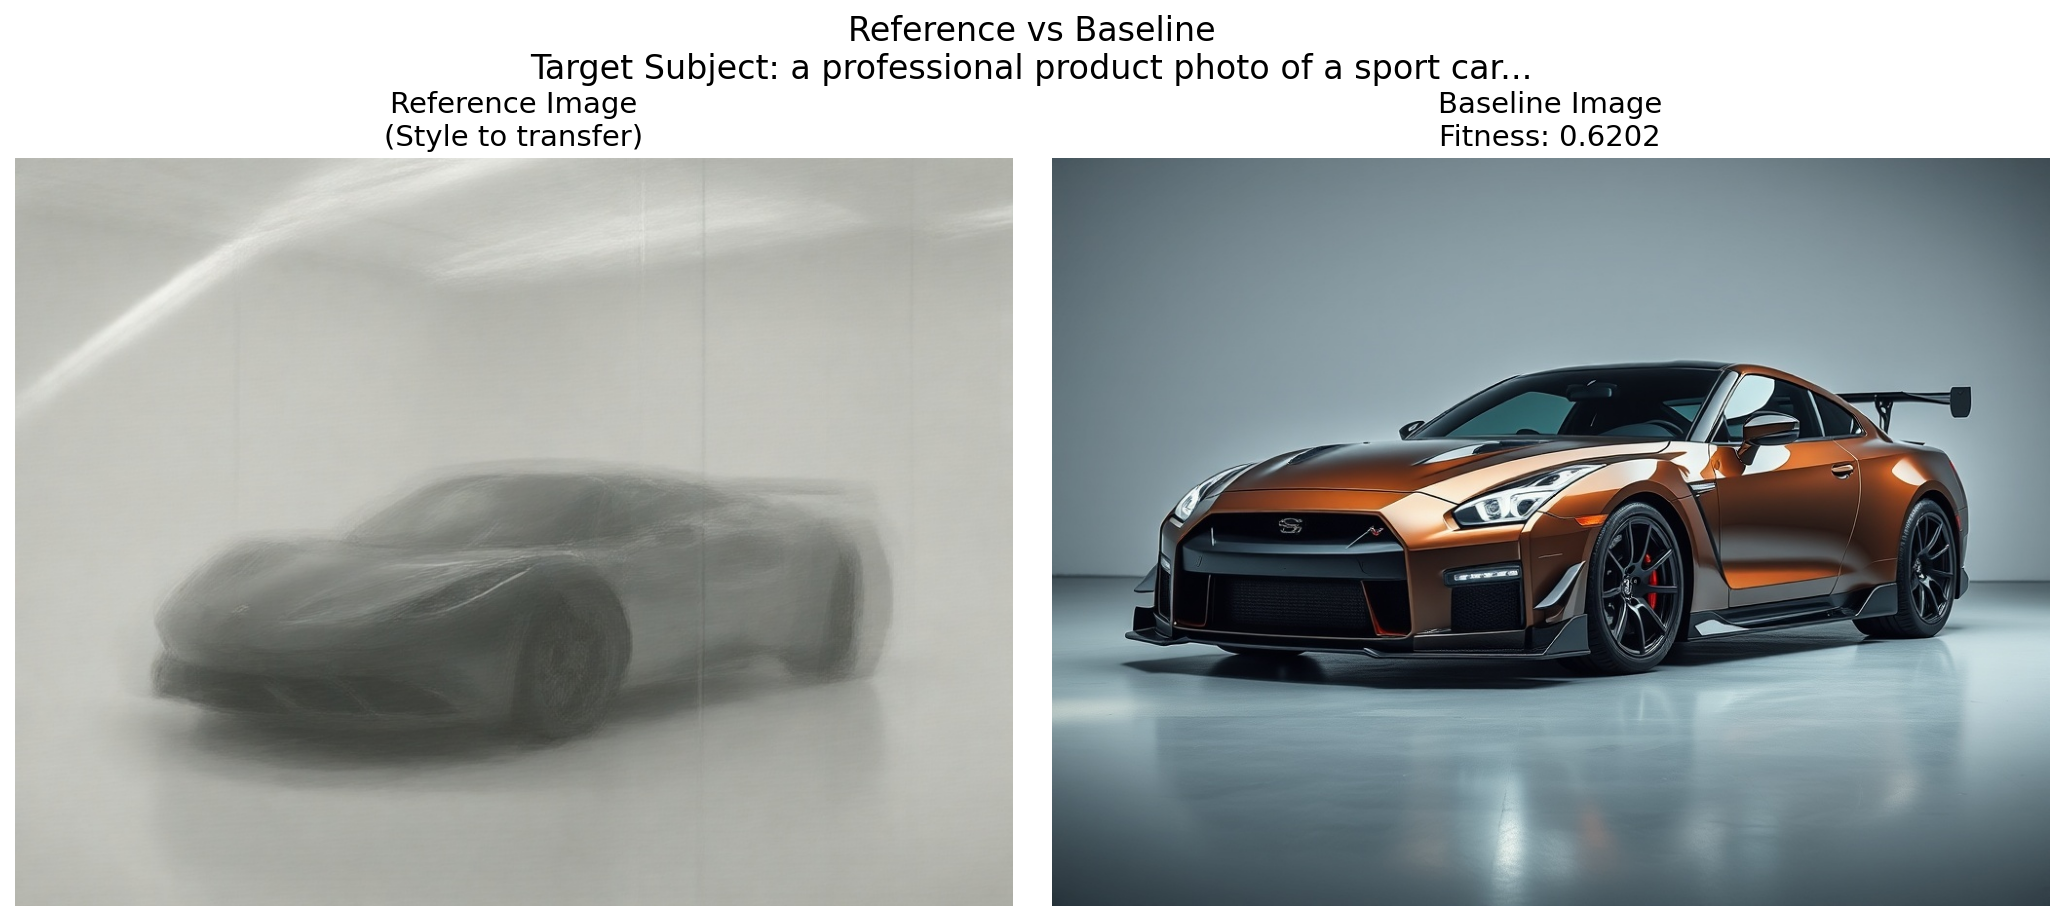

2025-12-30 17:38:51,045 - experiment_2 - INFO - Baseline evaluation complete. Score: 0.6202


In [6]:
# =============================================================================
# GENERATE AND EVALUATE BASELINE
# =============================================================================
# Baseline: Just the subject, no style modifiers

print("Generating baseline image (subject only, no modifiers)...")
print(f"Subject: {USER_SUBJECT}")
print()

# Create baseline genome (empty blocks)
baseline_genome = factory.create_empty(USER_SUBJECT)
print(f"Baseline genome:")
print(f"  Prompt: {baseline_genome.to_prompt()}")
print(f"  Negative: {baseline_genome.get_negative_prompt() or '(none)'}")

# Generate baseline image
try:
    # Check if model supports negative prompts
    if MODEL_NAME == "qwen-image":
        baseline_image, baseline_metadata = model.generate(
            prompt=baseline_genome.to_prompt(),
            negative_prompt=baseline_genome.get_negative_prompt() or None,
            image_size=IMAGE_SIZE,
            num_inference_steps=QWEN_INFERENCE_STEPS,
            guidance_scale=QWEN_GUIDANCE_SCALE,
            seed=GENERATION_SEED
        )
    else:
        # flux-schnell doesn't support negative prompts or guidance_scale
        # and has max 12 inference steps
        baseline_image, baseline_metadata = model.generate(
            prompt=baseline_genome.to_prompt(),
            image_size=IMAGE_SIZE,
            num_inference_steps=FLUX_INFERENCE_STEPS,
            seed=GENERATION_SEED
        )
    print("\nBaseline image generated successfully.")
except Exception as e:
    print(f"Error generating baseline image: {e}")
    raise

# Evaluate baseline fitness using static evaluator
print("\nEvaluating baseline fitness...")
baseline_score = static_evaluator.evaluate(
    image=baseline_image,
    text=USER_SUBJECT,
    verbose=True
)
print(f"\nBaseline Fitness Score: {baseline_score:.4f}")

# Save baseline image
baseline_path = OUTPUT_DIR / "baseline_image.jpg"
baseline_image.save(baseline_path)
print(f"Baseline image saved to: {baseline_path}")

# Display comparison: Reference vs Baseline
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(reference_image)
axes[0].set_title("Reference Image\n(Style to transfer)", fontsize=14)
axes[0].axis('off')

axes[1].imshow(baseline_image)
axes[1].set_title(f"Baseline Image\nFitness: {baseline_score:.4f}", fontsize=14)
axes[1].axis('off')

plt.suptitle(f"Reference vs Baseline\nTarget Subject: {USER_SUBJECT[:50]}...", fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "reference_vs_baseline.png", bbox_inches='tight')
plt.show()

# Log baseline results
logger.info(f"Baseline evaluation complete. Score: {baseline_score:.4f}")

## Cell 6: Helper Functions

In [7]:
def run_experiment(
    evaluator: TemplateFitnessEvaluator,
    experiment_name: str,
    llm_seeds: List[Dict[str, List[str]]],
    results_array: List[Dict],
    max_generations: int = MAX_GENERATIONS,
    save_every: int = SAVE_EVERY_N_GENERATIONS,
    is_adaptive: bool = False,
    save_all_images: bool = SAVE_ALL_IMAGES
) -> Tuple[Dict[str, Any], List[BlockGenome]]:
    """
    Run one complete evolutionary experiment with comprehensive image saving.
    
    Args:
        evaluator: Fitness evaluator (static or adaptive)
        experiment_name: Name for saving results
        llm_seeds: LLM-generated seed prompts for initialization
        results_array: List to store all results (prompts, images, fitness)
        max_generations: Maximum number of generations
        save_every: Save checkpoint every N generations
        is_adaptive: Whether using adaptive evaluator
        save_all_images: Whether to save all generated images
    
    Returns:
        history: Dict with fitness tracking per generation
        final_population: Final evolved population
    """
    # Create experiment output directory
    exp_dir = OUTPUT_DIR / experiment_name
    exp_dir.mkdir(parents=True, exist_ok=True)
    
    # Create images directory for all images
    images_dir = exp_dir / "all_images"
    images_dir.mkdir(parents=True, exist_ok=True)
    
    # Initialize tracking
    history = {
        'best_fitness': [],
        'avg_fitness': [],
        'worst_fitness': [],
        'diversity': [],
        'best_prompts': [],
        'clip_weights': [],
        'lpips_weights': [],
        'block_diversity': []
    }
    
    # Initialize population with LLM seeds
    print(f"Initializing population with LLM seeds...")
    population = engine.initialize_population(USER_SUBJECT, llm_seeds=llm_seeds)
    print(f"Population size: {len(population)}")
    
    # Evolution loop
    for generation in range(max_generations):
        print(f"\n--- Generation {generation + 1}/{max_generations} ---")
        
        # Update adaptive weights if using adaptive evaluator
        if is_adaptive:
            evaluator.update_generation(generation)
            current_clip_weight = evaluator.clip_weight
            current_lpips_weight = evaluator.lpips_weight
        else:
            current_clip_weight = STATIC_CLIP_WEIGHT
            current_lpips_weight = STATIC_LPIPS_WEIGHT
        
        history['clip_weights'].append(current_clip_weight)
        history['lpips_weights'].append(current_lpips_weight)
        
        print(f"Weights: CLIP={current_clip_weight:.2f}, LPIPS={current_lpips_weight:.2f}")
        
        # Evaluate fitness for all genomes
        gen_images = []
        for idx, genome in enumerate(tqdm(population, desc="Evaluating population")):
            try:
                # Generate image (check if model supports negative prompts)
                if MODEL_NAME == "qwen-image":
                    image, metadata = model.generate(
                        prompt=genome.to_prompt(),
                        negative_prompt=genome.get_negative_prompt() or None,
                        image_size=IMAGE_SIZE,
                        num_inference_steps=QWEN_INFERENCE_STEPS,
                        guidance_scale=QWEN_GUIDANCE_SCALE,
                        seed=GENERATION_SEED + generation * 100 + idx
                    )
                else:
                    # flux-schnell doesn't support negative prompts or guidance_scale
                    # and has max 12 inference steps
                    image, metadata = model.generate(
                        prompt=genome.to_prompt(),
                        image_size=IMAGE_SIZE,
                        num_inference_steps=FLUX_INFERENCE_STEPS,
                        seed=GENERATION_SEED + generation * 100 + idx
                    )
                
                # Evaluate fitness (using subject for CLIP)
                genome.fitness = evaluator.evaluate(image, USER_SUBJECT)
                gen_images.append((genome.fitness, image, genome.to_prompt(), genome))
                
                # Save image with generation index and fitness score
                if save_all_images:
                    img_filename = f"gen{generation+1:03d}_idx{idx:02d}_fit{genome.fitness:.4f}.jpg"
                    img_path = images_dir / img_filename
                    image.save(img_path)
                
                # Add to results array
                result_entry = {
                    'experiment': experiment_name,
                    'generation': generation + 1,
                    'individual_index': idx,
                    'prompt': genome.to_prompt(),
                    'negative_prompt': genome.get_negative_prompt(),
                    'blocks': {
                        'composition': genome.composition.copy(),
                        'lighting': genome.lighting.copy(),
                        'style': genome.style.copy(),
                        'quality': genome.quality.copy(),
                        'negative': genome.negative.copy()
                    },
                    'fitness': float(genome.fitness),
                    'image_path': str(img_path) if save_all_images else None,
                    'clip_weight': current_clip_weight,
                    'lpips_weight': current_lpips_weight
                }
                results_array.append(result_entry)
                
            except Exception as e:
                print(f"Error evaluating genome {idx}: {e}")
                genome.fitness = 0.0
        
        # Track fitness statistics
        fitnesses = [g.fitness for g in population]
        best_fitness = max(fitnesses)
        avg_fitness = np.mean(fitnesses)
        worst_fitness = min(fitnesses)
        
        # Get block-wise diversity
        diversity_dict = engine.get_diversity(population)
        overall_diversity = np.mean(list(diversity_dict.values()))
        
        history['best_fitness'].append(best_fitness)
        history['avg_fitness'].append(avg_fitness)
        history['worst_fitness'].append(worst_fitness)
        history['diversity'].append(overall_diversity)
        history['block_diversity'].append(diversity_dict)
        
        # Get best genome
        best_genome = engine.get_best(population)
        history['best_prompts'].append(best_genome.to_prompt())
        
        print(f"Best: {best_fitness:.4f} | Avg: {avg_fitness:.4f} | Diversity: {overall_diversity:.2f}")
        print(f"Best prompt: {best_genome.to_prompt()[:80]}...")
        
        # Save checkpoint
        if (generation + 1) % save_every == 0 or generation == max_generations - 1:
            checkpoint_dir = exp_dir / f"gen_{generation + 1:02d}"
            checkpoint_dir.mkdir(parents=True, exist_ok=True)
            
            # Save best image
            if gen_images:
                gen_images.sort(key=lambda x: x[0], reverse=True)
                best_img = gen_images[0][1]
                best_img.save(checkpoint_dir / "best_image.jpg")
            
            # Save checkpoint data
            checkpoint_data = {
                'generation': generation + 1,
                'best_fitness': best_fitness,
                'avg_fitness': avg_fitness,
                'best_prompt': best_genome.to_prompt(),
                'best_negative': best_genome.get_negative_prompt(),
                'blocks': {
                    'composition': best_genome.composition,
                    'lighting': best_genome.lighting,
                    'style': best_genome.style,
                    'quality': best_genome.quality,
                    'negative': best_genome.negative
                }
            }
            save_json(checkpoint_data, str(checkpoint_dir / "checkpoint.json"))
            print(f"Checkpoint saved to {checkpoint_dir}")
        
        # Evolve to next generation (except on last generation)
        if generation < max_generations - 1:
            population = engine.evolve_generation(population)
    
    # Save final results
    final_results = {
        'experiment_name': experiment_name,
        'generations': max_generations,
        'final_best_fitness': history['best_fitness'][-1],
        'final_avg_fitness': history['avg_fitness'][-1],
        'history': {
            'best_fitness': history['best_fitness'],
            'avg_fitness': history['avg_fitness'],
            'worst_fitness': history['worst_fitness'],
            'diversity': history['diversity'],
            'clip_weights': history['clip_weights'],
            'lpips_weights': history['lpips_weights']
        }
    }
    save_json(final_results, str(exp_dir / "final_results.json"))
    
    logger.info(f"{experiment_name} complete. Best fitness: {history['best_fitness'][-1]:.4f}")
    
    return history, population


def visualize_results(history: Dict[str, List], baseline_score: float, title: str = "Evolution Progress"):
    """
    Create publication-quality convergence plot.
    """
    generations = range(1, len(history['best_fitness']) + 1)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(generations, history['best_fitness'], 'g-', linewidth=2, 
            label='Best Fitness', marker='o', markersize=4)
    ax.plot(generations, history['avg_fitness'], 'b--', linewidth=1.5,
            label='Average Fitness', alpha=0.8)
    ax.fill_between(generations, history['worst_fitness'], history['best_fitness'],
                    alpha=0.2, color='green', label='Fitness Range')
    
    ax.axhline(y=baseline_score, color='orange', linestyle='-.', 
               linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    ax.set_xlabel('Generation')
    ax.set_ylabel('Fitness Score')
    ax.set_title(title)
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(1, len(generations))
    
    y_min = min(min(history['worst_fitness']), baseline_score) * 0.95
    y_max = max(history['best_fitness']) * 1.05
    ax.set_ylim(y_min, y_max)
    
    plt.tight_layout()
    return fig


def compare_experiments(
    exp1_history: Dict[str, List],
    exp2_history: Dict[str, List],
    baseline_score: float,
    exp1_name: str = "Static Weights",
    exp2_name: str = "Adaptive Weights"
):
    """
    Create side-by-side comparison plot for two experiments.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    generations = range(1, len(exp1_history['best_fitness']) + 1)
    
    ax1 = axes[0]
    ax1.plot(generations, exp1_history['best_fitness'], 'b-', linewidth=2,
             label=f'{exp1_name} (Best)', marker='o', markersize=4)
    ax1.plot(generations, exp2_history['best_fitness'], 'r-', linewidth=2,
             label=f'{exp2_name} (Best)', marker='s', markersize=4)
    ax1.axhline(y=baseline_score, color='orange', linestyle='-.', 
                linewidth=2, label=f'Baseline ({baseline_score:.4f})')
    
    ax1.set_xlabel('Generation')
    ax1.set_ylabel('Fitness Score')
    ax1.set_title('Best Fitness Comparison')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    ax2 = axes[1]
    ax2.plot(generations, exp1_history['clip_weights'], 'b--', linewidth=2,
             label=f'{exp1_name} CLIP Weight')
    ax2.plot(generations, exp2_history['clip_weights'], 'r-', linewidth=2,
             label=f'{exp2_name} CLIP Weight')
    ax2.plot(generations, exp2_history['lpips_weights'], 'r:', linewidth=2,
             label=f'{exp2_name} LPIPS Weight')
    
    ax2.set_xlabel('Generation')
    ax2.set_ylabel('Weight Value')
    ax2.set_title('Fitness Weight Evolution')
    ax2.legend(loc='center right')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    return fig


def generate_final_image(genome: BlockGenome, seed: int = GENERATION_SEED) -> Tuple[Image.Image, float]:
    """
    Generate final image for a genome with consistent seed.
    """
    # Check if model supports negative prompts
    if MODEL_NAME == "qwen-image":
        image, _ = model.generate(
            prompt=genome.to_prompt(),
            negative_prompt=genome.get_negative_prompt() or None,
            image_size=IMAGE_SIZE,
            num_inference_steps=QWEN_INFERENCE_STEPS,
            guidance_scale=QWEN_GUIDANCE_SCALE,
            seed=seed
        )
    else:
        # flux-schnell doesn't support negative prompts or guidance_scale
        # and has max 12 inference steps
        image, _ = model.generate(
            prompt=genome.to_prompt(),
            image_size=IMAGE_SIZE,
            num_inference_steps=FLUX_INFERENCE_STEPS,
            seed=seed
        )
    fitness = static_evaluator.evaluate(image, USER_SUBJECT)
    return image, fitness


print("Helper functions defined successfully.")

Helper functions defined successfully.


## Cell 7: Run Experiment 2.1 (Static Weights)

In [8]:
print("=" * 60)
print("EXPERIMENT 2.1: STATIC WEIGHTS")
print(f"CLIP Weight: {STATIC_CLIP_WEIGHT} (fixed)")
print(f"LPIPS Weight: {STATIC_LPIPS_WEIGHT} (fixed)")
print("=" * 60)

# Run experiment with static weights
static_history, static_population = run_experiment(
    evaluator=static_evaluator,
    experiment_name="exp2_1_static",
    llm_seeds=llm_seeds,
    results_array=ALL_RESULTS,
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=False
)

# Get best genome from static experiment
best_static_genome = max(static_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 2.1 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_static_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_static_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_static_genome.to_prompt()}")
print(f"\nNegative Prompt:")
print(f"  {best_static_genome.get_negative_prompt()}")
print(f"\nBlock Breakdown:")
print(f"  Composition: {best_static_genome.composition}")
print(f"  Lighting: {best_static_genome.lighting}")
print(f"  Style: {best_static_genome.style}")
print(f"  Quality: {best_static_genome.quality}")
print(f"  Negative: {best_static_genome.negative}")
print(f"\nTotal images generated so far: {len(ALL_RESULTS)}")

EXPERIMENT 2.1: STATIC WEIGHTS
CLIP Weight: 0.5 (fixed)
LPIPS Weight: 0.5 (fixed)
Initializing population with LLM seeds...
Population size: 20

--- Generation 1/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Best: 0.6373 | Avg: 0.6181 | Diversity: 0.12
Best prompt: a professional product photo of a sport car, high angle, full shot, seamless bac...

--- Generation 2/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6415 | Avg: 0.6122 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, minimalist composition, studio shot...

--- Generation 3/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6346 | Avg: 0.6105 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, studio shot, teleph...

--- Generation 4/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6387 | Avg: 0.6094 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, exploded view, abstract, eye-catchi...

--- Generation 5/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6310 | Avg: 0.6105 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, artifacts, layered composition, abs...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_05

--- Generation 6/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6403 | Avg: 0.6072 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, minimalist composition, studio shot...

--- Generation 7/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6378 | Avg: 0.6116 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, exploded view, hero shot, eye-catch...

--- Generation 8/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6305 | Avg: 0.6102 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, well-balanced scene, studio shot, t...

--- Generation 9/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6298 | Avg: 0.6084 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, birds-eye view, fra...

--- Generation 10/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6301 | Avg: 0.6109 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, birds-eye view, fra...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_10

--- Generation 11/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6365 | Avg: 0.6138 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, negative space, birds-eye view, fra...

--- Generation 12/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6325 | Avg: 0.6129 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, negative space, birds-eye view, fra...

--- Generation 13/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6369 | Avg: 0.6110 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, split diopter, mast...

--- Generation 14/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6271 | Avg: 0.6087 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, split diopter, line...

--- Generation 15/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6289 | Avg: 0.6072 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, photorealistic, medium shot, positi...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_15

--- Generation 16/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6295 | Avg: 0.6080 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, photorealistic, medium shot, positi...

--- Generation 17/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6258 | Avg: 0.6087 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, horizontal composition, abstract co...

--- Generation 18/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6308 | Avg: 0.6096 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, refined arrangement, linear perspec...

--- Generation 19/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6274 | Avg: 0.6080 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, refined arrangement, linear perspec...

--- Generation 20/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6248 | Avg: 0.6077 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, refined arrangement, linear perspec...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_20

--- Generation 21/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6281 | Avg: 0.6089 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, refined arrangement, linear perspec...

--- Generation 22/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6297 | Avg: 0.6128 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, hyperrealistic, geometric compositi...

--- Generation 23/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6279 | Avg: 0.6103 | Diversity: 0.15
Best prompt: a professional product photo of a sport car, anamorphic, linear perspective, sha...

--- Generation 24/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6297 | Avg: 0.6102 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, hyperrealistic, external framing, g...

--- Generation 25/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6356 | Avg: 0.6124 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, harmonic composition, cinemascope, ...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_25

--- Generation 26/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6282 | Avg: 0.6109 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, harmonic composition, cinemascope, ...

--- Generation 27/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6272 | Avg: 0.6102 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, harmonic composition, cinemascope, ...

--- Generation 28/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6250 | Avg: 0.6066 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, sparse composition, symmetrical bal...

--- Generation 29/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6368 | Avg: 0.6086 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, visually appealing, symmetrical bal...

--- Generation 30/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6284 | Avg: 0.6117 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, s-curve composition, artificial lig...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_30

--- Generation 31/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6284 | Avg: 0.6112 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, harmonic composition, practical lig...

--- Generation 32/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6273 | Avg: 0.6090 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, harmonic composition, practical lig...

--- Generation 33/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6403 | Avg: 0.6105 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, harmonic composition, practical lig...

--- Generation 34/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6400 | Avg: 0.6147 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, harmonic composition, grid layout, ...

--- Generation 35/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6312 | Avg: 0.6103 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, harmonic composition, grid layout, ...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_35

--- Generation 36/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6449 | Avg: 0.6127 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, photorealistic, refined arrangement...

--- Generation 37/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6374 | Avg: 0.6149 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, harmonic composition, classic, circ...

--- Generation 38/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6353 | Avg: 0.6118 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, harmonic composition, abstract comp...

--- Generation 39/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6362 | Avg: 0.6100 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, harmonic composition, abstract comp...

--- Generation 40/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6215 | Avg: 0.6090 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, harmonic composition, classic, circ...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_40

--- Generation 41/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6316 | Avg: 0.6093 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, neoclassical, brand identity, graph...

--- Generation 42/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6267 | Avg: 0.6094 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, harmonic composition, abstract comp...

--- Generation 43/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6263 | Avg: 0.6088 | Diversity: 0.15
Best prompt: a professional product photo of a sport car, halogen light, neoclassical, pencil...

--- Generation 44/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6387 | Avg: 0.6117 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, halogen light, neoclassical, pencil...

--- Generation 45/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6406 | Avg: 0.6106 | Diversity: 0.15
Best prompt: a professional product photo of a sport car, vertical composition, vanishing poi...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_45

--- Generation 46/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6295 | Avg: 0.6075 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, vertical composition, vanishing poi...

--- Generation 47/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6351 | Avg: 0.6103 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, visual impact, subtle shadows, subs...

--- Generation 48/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6319 | Avg: 0.6101 | Diversity: 0.14
Best prompt: a professional product photo of a sport car, stylized, dadaism, nanotechnology a...

--- Generation 49/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6334 | Avg: 0.6103 | Diversity: 0.14
Best prompt: a professional product photo of a sport car, creating interest, abstract forms, ...

--- Generation 50/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6340 | Avg: 0.6136 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, creating interest, abstract forms, ...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_50

--- Generation 51/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6335 | Avg: 0.6100 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, high resolution, rule of thirds, cl...

--- Generation 52/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6262 | Avg: 0.6058 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, clear foreground, slow sync flash, ...

--- Generation 53/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6288 | Avg: 0.6091 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, perfect composition, s-curve compos...

--- Generation 54/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6358 | Avg: 0.6062 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, clear foreground, overcast light, a...

--- Generation 55/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6268 | Avg: 0.6073 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, ground level shot, background, bad ...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_55

--- Generation 56/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6180 | Avg: 0.6012 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, dreamlike, abstract, wide-angle len...

--- Generation 57/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6382 | Avg: 0.6102 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, clean, overcast light, special effe...

--- Generation 58/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6278 | Avg: 0.6068 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, clean, overcast light, special effe...

--- Generation 59/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6336 | Avg: 0.6050 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, graphic, drawing the eye, soft ligh...

--- Generation 60/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6453 | Avg: 0.6154 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, natural light, misalignment, isolat...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_60

--- Generation 61/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6348 | Avg: 0.6107 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, birds-eye view, negative space, wor...

--- Generation 62/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6305 | Avg: 0.6100 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, sense of scale, negative space, wor...

--- Generation 63/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6376 | Avg: 0.6071 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, sense of scale, negative space, wor...

--- Generation 64/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6404 | Avg: 0.6114 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, illustrative, layered composition, ...

--- Generation 65/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6436 | Avg: 0.6135 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, negative space, compositional balan...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_65

--- Generation 66/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6340 | Avg: 0.6151 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, unusual angle, radial balance, spar...

--- Generation 67/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6440 | Avg: 0.6130 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, negative space, carefully crafted c...

--- Generation 68/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6443 | Avg: 0.6110 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, negative space, carefully crafted c...

--- Generation 69/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6506 | Avg: 0.6160 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, negative space, carefully crafted c...

--- Generation 70/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6363 | Avg: 0.6072 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, negative space, radial balance, spa...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_70

--- Generation 71/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6459 | Avg: 0.6106 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, negative space, radial balance, spa...

--- Generation 72/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6468 | Avg: 0.6158 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, negative space, radial balance, spa...

--- Generation 73/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6381 | Avg: 0.6120 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, radial balance, spa...

--- Generation 74/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6276 | Avg: 0.6095 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, radial balance, spa...

--- Generation 75/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6362 | Avg: 0.6114 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, radial balance, spa...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_75

--- Generation 76/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6397 | Avg: 0.6148 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, radial balance, spa...

--- Generation 77/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6381 | Avg: 0.6151 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, radial balance, spa...

--- Generation 78/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6368 | Avg: 0.6131 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, negative space, clear, hero shot, t...

--- Generation 79/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6286 | Avg: 0.6068 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, negative space, clear, hero shot, t...

--- Generation 80/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6390 | Avg: 0.6107 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, clear, hero shot, t...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_80

--- Generation 81/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6454 | Avg: 0.6138 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, clean, eye-level, background, crisp...

--- Generation 82/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6477 | Avg: 0.6141 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, focal point, static...

--- Generation 83/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6389 | Avg: 0.6122 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, clear, hero shot, s...

--- Generation 84/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6424 | Avg: 0.6079 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, clear, hero shot, s...

--- Generation 85/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6261 | Avg: 0.6074 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, product placement, retro, full shot...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_85

--- Generation 86/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6311 | Avg: 0.6092 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, sparse composition, professional, g...

--- Generation 87/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6294 | Avg: 0.6123 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, sparse composition, professional, g...

--- Generation 88/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6218 | Avg: 0.6062 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, medium shot, well-balanced scene, s...

--- Generation 89/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6256 | Avg: 0.6096 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, procedural art, figure drawing, edi...

--- Generation 90/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6361 | Avg: 0.6106 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, portrait orientation, classic, geom...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_90

--- Generation 91/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6296 | Avg: 0.6082 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, shape contrast, refined arrangement...

--- Generation 92/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6209 | Avg: 0.6081 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, sparse composition, vertical compos...

--- Generation 93/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6259 | Avg: 0.6081 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, hard shadows, human-centered design...

--- Generation 94/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6177 | Avg: 0.6075 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, offset composition, classic, extern...

--- Generation 95/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6261 | Avg: 0.6107 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, key light, positive space, abstract...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_95

--- Generation 96/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6449 | Avg: 0.6117 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, key light, positive space, abstract...

--- Generation 97/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6330 | Avg: 0.6113 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, medium shot, positive space, abstra...

--- Generation 98/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6288 | Avg: 0.6097 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, medium shot, positive space, abstra...

--- Generation 99/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6442 | Avg: 0.6125 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, medium shot, positive space, abstra...

--- Generation 100/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6244 | Avg: 0.6102 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, medium shot, positive space, abstra...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_100

--- Generation 101/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6433 | Avg: 0.6142 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, medium shot, positive space, abstra...

--- Generation 102/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6348 | Avg: 0.6148 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, medium shot, positive space, abstra...

--- Generation 103/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6280 | Avg: 0.6072 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, distortion, positive space, abstrac...

--- Generation 104/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6273 | Avg: 0.6124 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, distortion, positive space, abstrac...

--- Generation 105/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6380 | Avg: 0.6131 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, medium shot, sense of calm, circula...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_105

--- Generation 106/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6441 | Avg: 0.6145 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, medium shot, sense of calm, circula...

--- Generation 107/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6288 | Avg: 0.6120 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, medium shot, sense of calm, explode...

--- Generation 108/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6325 | Avg: 0.6132 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, triangle composition, canted angle,...

--- Generation 109/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6242 | Avg: 0.6055 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, soft light, canted angle, abstract ...

--- Generation 110/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6337 | Avg: 0.6102 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, triptych, grid layout, sense of spe...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_110

--- Generation 111/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6275 | Avg: 0.6065 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, blur, canted angle, abstract forms,...

--- Generation 112/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6331 | Avg: 0.6101 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, shape contrast, overlapping element...

--- Generation 113/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6258 | Avg: 0.6095 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, geometric composition, symmetry, mo...

--- Generation 114/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6253 | Avg: 0.6099 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, blurred background, converging line...

--- Generation 115/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6242 | Avg: 0.6064 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, s-curve composition, surrounding en...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_115

--- Generation 116/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6344 | Avg: 0.6082 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, vertical composition, horizontal co...

--- Generation 117/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6306 | Avg: 0.6101 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, vertical composition, horizontal co...

--- Generation 118/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6413 | Avg: 0.6118 | Diversity: 0.15
Best prompt: a professional product photo of a sport car, unobstructed view, sparse compositi...

--- Generation 119/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6237 | Avg: 0.6096 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, smooth highlights, romantic lightin...

--- Generation 120/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6296 | Avg: 0.6096 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, aberration, sparse composition, lin...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_120

--- Generation 121/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6507 | Avg: 0.6135 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, positive space, sparse composition,...

--- Generation 122/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6422 | Avg: 0.6092 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, positive space, sparse composition,...

--- Generation 123/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6432 | Avg: 0.6154 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, positive space, sparse composition,...

--- Generation 124/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6473 | Avg: 0.6177 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, positive space, sparse composition,...

--- Generation 125/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6415 | Avg: 0.6155 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, isolating the subject, dynamic angl...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_125

--- Generation 126/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6498 | Avg: 0.6117 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, grid layout, sparse composition, st...

--- Generation 127/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6480 | Avg: 0.6168 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, positive space, sparse composition,...

--- Generation 128/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6366 | Avg: 0.6171 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, positive space, leading lines, futu...

--- Generation 129/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6476 | Avg: 0.6160 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, clean, establishing context, sparse...

--- Generation 130/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6430 | Avg: 0.6162 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_130

--- Generation 131/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6485 | Avg: 0.6138 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...

--- Generation 132/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6509 | Avg: 0.6154 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...

--- Generation 133/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6366 | Avg: 0.6112 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...

--- Generation 134/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6190 | Avg: 0.6078 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, diffused light, perfect composition...

--- Generation 135/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6392 | Avg: 0.6115 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_135

--- Generation 136/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6463 | Avg: 0.6145 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...

--- Generation 137/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6392 | Avg: 0.6185 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...

--- Generation 138/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6404 | Avg: 0.6189 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...

--- Generation 139/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6339 | Avg: 0.6114 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...

--- Generation 140/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6392 | Avg: 0.6120 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_140

--- Generation 141/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6282 | Avg: 0.6084 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, artificial light, positive space, s...

--- Generation 142/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6308 | Avg: 0.6100 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, creative perspective, sense of stil...

--- Generation 143/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6260 | Avg: 0.6088 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, diffused light, naturalism, highly ...

--- Generation 144/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6339 | Avg: 0.6104 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, pre-raphaelitism, performance art, ...

--- Generation 145/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6442 | Avg: 0.6099 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, eye-level, creating interest, spars...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_145

--- Generation 146/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6399 | Avg: 0.6138 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, eye-level, creating interest, spars...

--- Generation 147/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6323 | Avg: 0.6104 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, eye-level, creating interest, spars...

--- Generation 148/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6238 | Avg: 0.6077 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, eye-level, creating interest, spars...

--- Generation 149/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6256 | Avg: 0.6085 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, eye-level, creating interest, spars...

--- Generation 150/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

2025-12-30 19:32:12,076 - experiment_2 - INFO - exp2_1_static complete. Best fitness: 0.6319


Best: 0.6319 | Avg: 0.6105 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, photorealistic, sharp, diagonal com...
Checkpoint saved to ../data/results/experiment_2/exp2_1_static/gen_150

EXPERIMENT 2.1 RESULTS
Final Best Fitness: 0.6319
Improvement over baseline: 1.87%

Best Prompt:
  a professional product photo of a sport car, photorealistic, sharp, diagonal composition, low-key lighting, neutral light, softbox, octabox, direct sunlight, polaroid, installation art, geometric abstraction, architectural photography, game art, digital art, digital asset management, artifact removal, cloud computing

Negative Prompt:
  copyright infringement, social unrest, corruption

Block Breakdown:
  Composition: ['photorealistic', 'sharp', 'diagonal composition']
  Lighting: ['low-key lighting', 'neutral light', 'softbox', 'octabox', 'direct sunlight']
  Style: ['polaroid', 'installation art', 'geometric abstraction', 'architectural photography', 'game art']
  Quality: ['d

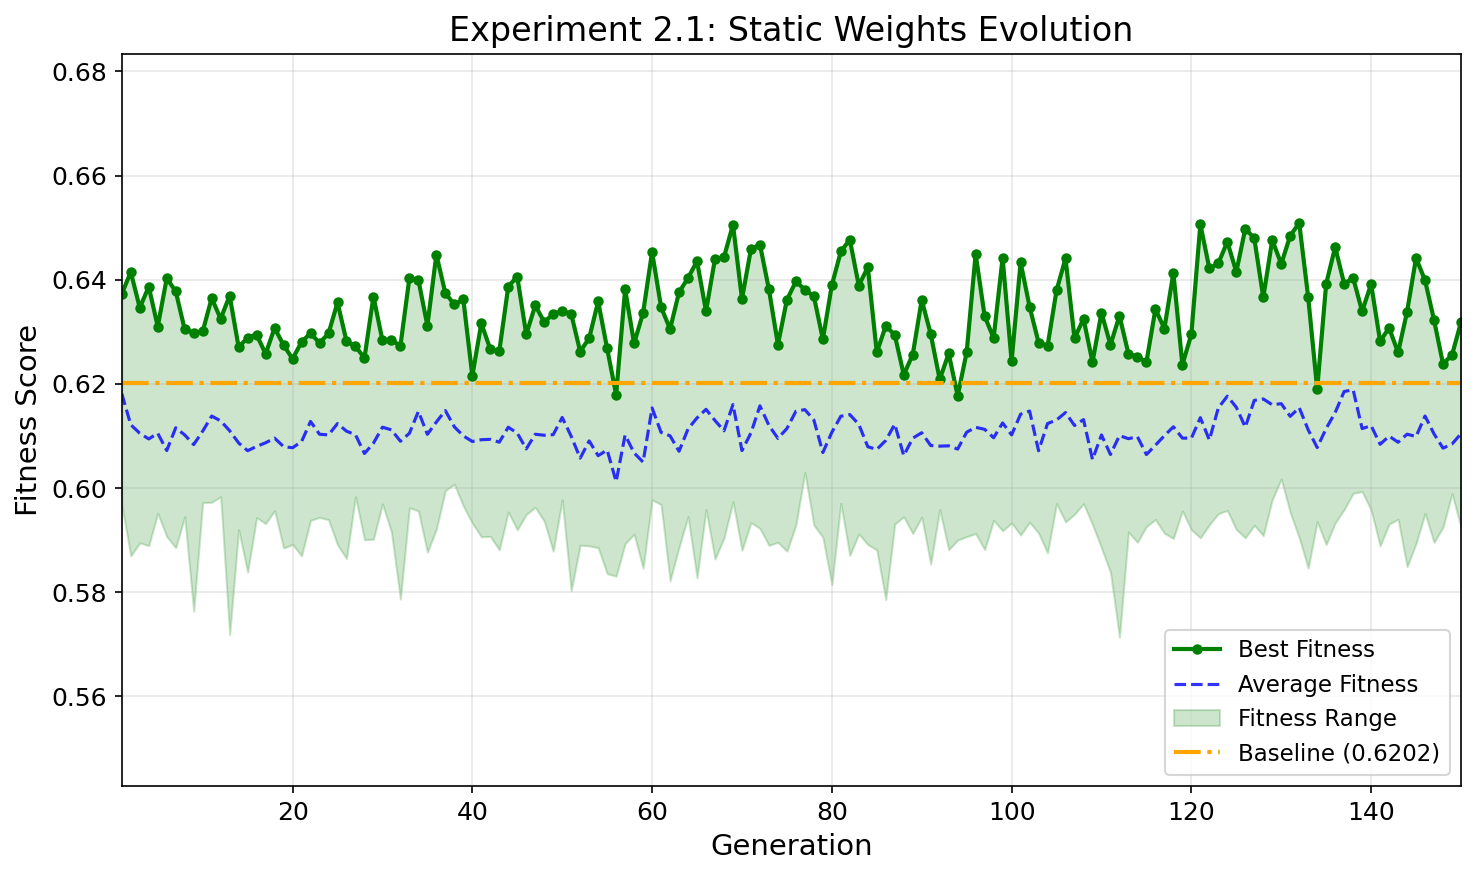

In [ ]:
# Visualize static experiment convergence
fig_static = visualize_results(
    static_history, 
    baseline_score,
    title="Experiment 2.1: Static Weights Evolution"
)
fig_static.savefig(OUTPUT_DIR / "exp2_1_convergence.png")
plt.show()

## Cell 8: Run Experiment 2.2 (Adaptive Weights)

In [10]:
print("=" * 60)
print("EXPERIMENT 2.2: ADAPTIVE WEIGHTS")
print(f"CLIP Weight: {INITIAL_CLIP_WEIGHT} -> {FINAL_CLIP_WEIGHT}")
print(f"LPIPS Weight: {1-INITIAL_CLIP_WEIGHT} -> {1-FINAL_CLIP_WEIGHT}")
print("Strategy: Start structure-focused (LPIPS), end content-focused (CLIP)")
print("=" * 60)

# Re-create adaptive evaluator to reset state
adaptive_evaluator = AdaptiveTemplateFitnessEvaluator(
    reference_image=reference_image,
    initial_clip_weight=INITIAL_CLIP_WEIGHT,
    final_clip_weight=FINAL_CLIP_WEIGHT,
    max_generations=MAX_GENERATIONS
)

# Run experiment with adaptive weights
adaptive_history, adaptive_population = run_experiment(
    evaluator=adaptive_evaluator,
    experiment_name="exp2_2_adaptive",
    llm_seeds=llm_seeds,
    results_array=ALL_RESULTS,
    max_generations=MAX_GENERATIONS,
    save_every=SAVE_EVERY_N_GENERATIONS,
    is_adaptive=True
)

# Get best genome from adaptive experiment
best_adaptive_genome = max(adaptive_population, key=lambda g: g.fitness)

print("\n" + "=" * 60)
print("EXPERIMENT 2.2 RESULTS")
print("=" * 60)
print(f"Final Best Fitness: {best_adaptive_genome.fitness:.4f}")
print(f"Improvement over baseline: {(best_adaptive_genome.fitness - baseline_score) / baseline_score * 100:.2f}%")
print(f"\nBest Prompt:")
print(f"  {best_adaptive_genome.to_prompt()}")
print(f"\nNegative Prompt:")
print(f"  {best_adaptive_genome.get_negative_prompt()}")
print(f"\nBlock Breakdown:")
print(f"  Composition: {best_adaptive_genome.composition}")
print(f"  Lighting: {best_adaptive_genome.lighting}")
print(f"  Style: {best_adaptive_genome.style}")
print(f"  Quality: {best_adaptive_genome.quality}")
print(f"  Negative: {best_adaptive_genome.negative}")
print(f"\nTotal images generated: {len(ALL_RESULTS)}")

EXPERIMENT 2.2: ADAPTIVE WEIGHTS
CLIP Weight: 0.3 -> 0.6
LPIPS Weight: 0.7 -> 0.4
Strategy: Start structure-focused (LPIPS), end content-focused (CLIP)
Initializing models on cpu...
CLIP model loaded
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/dogukantopcu/Desktop/jobs/hubx/projects/epe-image-generation-v4/evolutionary-prompt-engineering/venv/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth
LPIPS model loaded
Reference image preprocessed
Initializing population with LLM seeds...
Population size: 20

--- Generation 1/150 ---
Weights: CLIP=0.30, LPIPS=0.70


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6353 | Avg: 0.6114 | Diversity: 0.12
Best prompt: a professional product photo of a sport car, high angle, full shot, seamless bac...

--- Generation 2/150 ---
Weights: CLIP=0.30, LPIPS=0.70


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6318 | Avg: 0.6031 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, vertical composition, centered, vis...

--- Generation 3/150 ---
Weights: CLIP=0.30, LPIPS=0.70


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6412 | Avg: 0.6016 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, exploded view, centered, visual imp...

--- Generation 4/150 ---
Weights: CLIP=0.31, LPIPS=0.69


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6362 | Avg: 0.5999 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, forced perspective, telephoto lens,...

--- Generation 5/150 ---
Weights: CLIP=0.31, LPIPS=0.69


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6364 | Avg: 0.5981 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, off-center composition, negative sp...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_05

--- Generation 6/150 ---
Weights: CLIP=0.31, LPIPS=0.69


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6232 | Avg: 0.5977 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, off-center composition, negative sp...

--- Generation 7/150 ---
Weights: CLIP=0.31, LPIPS=0.69


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6380 | Avg: 0.6069 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, soft ambient light,...

--- Generation 8/150 ---
Weights: CLIP=0.31, LPIPS=0.69


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6294 | Avg: 0.5984 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, soft ambient light,...

--- Generation 9/150 ---
Weights: CLIP=0.32, LPIPS=0.68


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6276 | Avg: 0.5994 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, off-center composition, negative sp...

--- Generation 10/150 ---
Weights: CLIP=0.32, LPIPS=0.68


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6474 | Avg: 0.6031 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, minimalist composition, negative sp...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_10

--- Generation 11/150 ---
Weights: CLIP=0.32, LPIPS=0.68


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6478 | Avg: 0.6037 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, minimalist composition, negative sp...

--- Generation 12/150 ---
Weights: CLIP=0.32, LPIPS=0.68


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6304 | Avg: 0.5992 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, abstract forms, negative space, gra...

--- Generation 13/150 ---
Weights: CLIP=0.32, LPIPS=0.68


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6486 | Avg: 0.6026 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, minimalist composition, negative sp...

--- Generation 14/150 ---
Weights: CLIP=0.33, LPIPS=0.67


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6244 | Avg: 0.5968 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, forced perspective, striking image,...

--- Generation 15/150 ---
Weights: CLIP=0.33, LPIPS=0.67


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6144 | Avg: 0.5911 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, side view, bottom view, outdoor set...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_15

--- Generation 16/150 ---
Weights: CLIP=0.33, LPIPS=0.67


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6341 | Avg: 0.5995 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, foreground, centered composition, c...

--- Generation 17/150 ---
Weights: CLIP=0.33, LPIPS=0.67


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6192 | Avg: 0.6010 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, side view, bottom view, outdoor set...

--- Generation 18/150 ---
Weights: CLIP=0.33, LPIPS=0.67


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6195 | Avg: 0.5985 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, ellipsoidal reflector spotlight, bo...

--- Generation 19/150 ---
Weights: CLIP=0.34, LPIPS=0.66


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6356 | Avg: 0.5998 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, continuous lighting, classic lighti...

--- Generation 20/150 ---
Weights: CLIP=0.34, LPIPS=0.66


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6332 | Avg: 0.6008 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, continuous lighting, classic lighti...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_20

--- Generation 21/150 ---
Weights: CLIP=0.34, LPIPS=0.66


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6167 | Avg: 0.5989 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, continuous lighting, classic lighti...

--- Generation 22/150 ---
Weights: CLIP=0.34, LPIPS=0.66


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6359 | Avg: 0.5973 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, shape contrast, geometric shapes, b...

--- Generation 23/150 ---
Weights: CLIP=0.34, LPIPS=0.66


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6202 | Avg: 0.5998 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, highlights, strip box, butterfly li...

--- Generation 24/150 ---
Weights: CLIP=0.35, LPIPS=0.65


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6256 | Avg: 0.6001 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, minimalist composition, geometric s...

--- Generation 25/150 ---
Weights: CLIP=0.35, LPIPS=0.65


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6094 | Avg: 0.5998 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, minimalist composition, single-sour...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_25

--- Generation 26/150 ---
Weights: CLIP=0.35, LPIPS=0.65


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6277 | Avg: 0.6011 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, product placement, ...

--- Generation 27/150 ---
Weights: CLIP=0.35, LPIPS=0.65


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6286 | Avg: 0.6058 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, product placement, ...

--- Generation 28/150 ---
Weights: CLIP=0.35, LPIPS=0.65


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6394 | Avg: 0.6057 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, negative space, abstract, size cont...

--- Generation 29/150 ---
Weights: CLIP=0.36, LPIPS=0.64


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6402 | Avg: 0.6092 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, negative space, abstract, size cont...

--- Generation 30/150 ---
Weights: CLIP=0.36, LPIPS=0.64


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6383 | Avg: 0.6031 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, abstract, static sh...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_30

--- Generation 31/150 ---
Weights: CLIP=0.36, LPIPS=0.64


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6331 | Avg: 0.6005 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, negative space, full shot, external...

--- Generation 32/150 ---
Weights: CLIP=0.36, LPIPS=0.64


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6336 | Avg: 0.6026 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, book illustration, conceptual art, ...

--- Generation 33/150 ---
Weights: CLIP=0.36, LPIPS=0.64


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6302 | Avg: 0.6007 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, even lighting, smooth highlights, i...

--- Generation 34/150 ---
Weights: CLIP=0.37, LPIPS=0.63


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6355 | Avg: 0.5965 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, negative space, stylized, extreme c...

--- Generation 35/150 ---
Weights: CLIP=0.37, LPIPS=0.63


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6162 | Avg: 0.5980 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, negative space, stylized, extreme c...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_35

--- Generation 36/150 ---
Weights: CLIP=0.37, LPIPS=0.63


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6514 | Avg: 0.6040 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, negative space, stylized, extreme c...

--- Generation 37/150 ---
Weights: CLIP=0.37, LPIPS=0.63


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6434 | Avg: 0.6051 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, negative space, painterly, stylized...

--- Generation 38/150 ---
Weights: CLIP=0.37, LPIPS=0.63


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6279 | Avg: 0.6048 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, compositional balance, practical li...

--- Generation 39/150 ---
Weights: CLIP=0.38, LPIPS=0.62


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6373 | Avg: 0.6047 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, eye-catching composition, practical...

--- Generation 40/150 ---
Weights: CLIP=0.38, LPIPS=0.62


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6242 | Avg: 0.5999 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, eye-catching composition, practical...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_40

--- Generation 41/150 ---
Weights: CLIP=0.38, LPIPS=0.62


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6415 | Avg: 0.6026 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, classic, carefully crafted composit...

--- Generation 42/150 ---
Weights: CLIP=0.38, LPIPS=0.62


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6334 | Avg: 0.6088 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, classic, carefully crafted composit...

--- Generation 43/150 ---
Weights: CLIP=0.38, LPIPS=0.62


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6375 | Avg: 0.6023 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, classic, carefully crafted composit...

--- Generation 44/150 ---
Weights: CLIP=0.39, LPIPS=0.61


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6539 | Avg: 0.6094 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, classic, carefully crafted composit...

--- Generation 45/150 ---
Weights: CLIP=0.39, LPIPS=0.61


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6245 | Avg: 0.6055 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, off-center composition, centered co...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_45

--- Generation 46/150 ---
Weights: CLIP=0.39, LPIPS=0.61


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6491 | Avg: 0.6128 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, exploded view, carefully crafted co...

--- Generation 47/150 ---
Weights: CLIP=0.39, LPIPS=0.61


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6260 | Avg: 0.6061 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, off-center composition, clear, cont...

--- Generation 48/150 ---
Weights: CLIP=0.39, LPIPS=0.61


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6349 | Avg: 0.6085 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, off-center composition, clear, cont...

--- Generation 49/150 ---
Weights: CLIP=0.40, LPIPS=0.60


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6235 | Avg: 0.6069 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, ground level shot, sharp, organic c...

--- Generation 50/150 ---
Weights: CLIP=0.40, LPIPS=0.60


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6237 | Avg: 0.6037 | Diversity: 0.23
Best prompt: a professional product photo of a sport car, futuristic, radial balance, sense o...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_50

--- Generation 51/150 ---
Weights: CLIP=0.40, LPIPS=0.60


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6400 | Avg: 0.6046 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, modern, sense of stillness, long sh...

--- Generation 52/150 ---
Weights: CLIP=0.40, LPIPS=0.60


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6338 | Avg: 0.6039 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, modern, sense of stillness, long sh...

--- Generation 53/150 ---
Weights: CLIP=0.40, LPIPS=0.60


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6203 | Avg: 0.6010 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, harmonious arrangement, artistic, g...

--- Generation 54/150 ---
Weights: CLIP=0.41, LPIPS=0.59


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6402 | Avg: 0.6057 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, contrast, clear, sense of scale, ho...

--- Generation 55/150 ---
Weights: CLIP=0.41, LPIPS=0.59


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6360 | Avg: 0.6076 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, modern, sense of stillness, long sh...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_55

--- Generation 56/150 ---
Weights: CLIP=0.41, LPIPS=0.59


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6242 | Avg: 0.6038 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, contrast, clear, sense of scale, ho...

--- Generation 57/150 ---
Weights: CLIP=0.41, LPIPS=0.59


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6449 | Avg: 0.6071 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, contrast, clear, sense of scale, ho...

--- Generation 58/150 ---
Weights: CLIP=0.41, LPIPS=0.59


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6293 | Avg: 0.6065 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, negative space, harmonic compositio...

--- Generation 59/150 ---
Weights: CLIP=0.42, LPIPS=0.58


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6142 | Avg: 0.6027 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, modern, graphic, eye-catching compo...

--- Generation 60/150 ---
Weights: CLIP=0.42, LPIPS=0.58


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6280 | Avg: 0.6057 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, modern, poorly framed, motion blur,...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_60

--- Generation 61/150 ---
Weights: CLIP=0.42, LPIPS=0.58


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6215 | Avg: 0.6036 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, square orientation, side view, spec...

--- Generation 62/150 ---
Weights: CLIP=0.42, LPIPS=0.58


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6247 | Avg: 0.5987 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, sense of stillness, side view, arti...

--- Generation 63/150 ---
Weights: CLIP=0.42, LPIPS=0.58


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6287 | Avg: 0.6007 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, artificial light, z-axis compositio...

--- Generation 64/150 ---
Weights: CLIP=0.43, LPIPS=0.57


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6237 | Avg: 0.6035 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, square orientation, side view, clea...

--- Generation 65/150 ---
Weights: CLIP=0.43, LPIPS=0.57


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6223 | Avg: 0.5999 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, sense of stillness, artifacts, prod...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_65

--- Generation 66/150 ---
Weights: CLIP=0.43, LPIPS=0.57


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6299 | Avg: 0.6067 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, sense of stillness, artifacts, port...

--- Generation 67/150 ---
Weights: CLIP=0.43, LPIPS=0.57


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6383 | Avg: 0.6082 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, detailed, minimalist composition, p...

--- Generation 68/150 ---
Weights: CLIP=0.43, LPIPS=0.57


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6220 | Avg: 0.6057 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, static shot, full shot, sense of st...

--- Generation 69/150 ---
Weights: CLIP=0.44, LPIPS=0.56


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6298 | Avg: 0.6077 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, static shot, full shot, sense of st...

--- Generation 70/150 ---
Weights: CLIP=0.44, LPIPS=0.56


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6286 | Avg: 0.6018 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, static shot, full shot, sense of st...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_70

--- Generation 71/150 ---
Weights: CLIP=0.44, LPIPS=0.56


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6240 | Avg: 0.6086 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, static shot, full shot, sense of st...

--- Generation 72/150 ---
Weights: CLIP=0.44, LPIPS=0.56


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6435 | Avg: 0.6085 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, static shot, full shot, sense of st...

--- Generation 73/150 ---
Weights: CLIP=0.44, LPIPS=0.56


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6292 | Avg: 0.6066 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, 3/4 view, golden ratio, underglow, ...

--- Generation 74/150 ---
Weights: CLIP=0.45, LPIPS=0.55


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6356 | Avg: 0.6121 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, soft light, charcoal drawing, macro...

--- Generation 75/150 ---
Weights: CLIP=0.45, LPIPS=0.55


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6435 | Avg: 0.6097 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, diagonal composition, eye-level, sh...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_75

--- Generation 76/150 ---
Weights: CLIP=0.45, LPIPS=0.55


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6341 | Avg: 0.6111 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, diagonal composition, framing, diff...

--- Generation 77/150 ---
Weights: CLIP=0.45, LPIPS=0.55


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6409 | Avg: 0.6124 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, clean, ambient light, atmospheric p...

--- Generation 78/150 ---
Weights: CLIP=0.45, LPIPS=0.55


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6314 | Avg: 0.6090 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, clean, ambient light, atmospheric p...

--- Generation 79/150 ---
Weights: CLIP=0.46, LPIPS=0.54


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6254 | Avg: 0.6044 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, clean, ambient light, atmospheric p...

--- Generation 80/150 ---
Weights: CLIP=0.46, LPIPS=0.54


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6216 | Avg: 0.6004 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, clean, ambient light, atmospheric p...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_80

--- Generation 81/150 ---
Weights: CLIP=0.46, LPIPS=0.54


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6385 | Avg: 0.6122 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, directional light, harmonic composi...

--- Generation 82/150 ---
Weights: CLIP=0.46, LPIPS=0.54


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6329 | Avg: 0.6134 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, product placement, diagonal composi...

--- Generation 83/150 ---
Weights: CLIP=0.46, LPIPS=0.54


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6410 | Avg: 0.6104 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, refined arrangement, point-of-view ...

--- Generation 84/150 ---
Weights: CLIP=0.47, LPIPS=0.53


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6299 | Avg: 0.6081 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, fisheye lens, dutch angle, fill lig...

--- Generation 85/150 ---
Weights: CLIP=0.47, LPIPS=0.53


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6307 | Avg: 0.6069 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, refined arrangement, soft focus, ab...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_85

--- Generation 86/150 ---
Weights: CLIP=0.47, LPIPS=0.53


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6375 | Avg: 0.6119 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, refined arrangement, soft focus, ab...

--- Generation 87/150 ---
Weights: CLIP=0.47, LPIPS=0.53


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6362 | Avg: 0.6075 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, refined arrangement, soft focus, ab...

--- Generation 88/150 ---
Weights: CLIP=0.47, LPIPS=0.53


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6214 | Avg: 0.6089 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, refined arrangement, soft focus, ab...

--- Generation 89/150 ---
Weights: CLIP=0.48, LPIPS=0.52


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6395 | Avg: 0.6083 | Diversity: 0.13
Best prompt: a professional product photo of a sport car, refined arrangement, soft focus, ab...

--- Generation 90/150 ---
Weights: CLIP=0.48, LPIPS=0.52


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6349 | Avg: 0.6084 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, refined arrangement, artistic, abst...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_90

--- Generation 91/150 ---
Weights: CLIP=0.48, LPIPS=0.52


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6226 | Avg: 0.6065 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, refined arrangement, shape contrast...

--- Generation 92/150 ---
Weights: CLIP=0.48, LPIPS=0.52


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6355 | Avg: 0.6091 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, shape contrast, symmetry, balanced ...

--- Generation 93/150 ---
Weights: CLIP=0.48, LPIPS=0.52


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6397 | Avg: 0.6123 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, balanced elements, front view, mini...

--- Generation 94/150 ---
Weights: CLIP=0.49, LPIPS=0.51


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6446 | Avg: 0.6125 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, balanced elements, front view, mini...

--- Generation 95/150 ---
Weights: CLIP=0.49, LPIPS=0.51


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6299 | Avg: 0.6078 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, high resolution, primary subject, s...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_95

--- Generation 96/150 ---
Weights: CLIP=0.49, LPIPS=0.51


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6279 | Avg: 0.6042 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, vintage, harmonic composition, flas...

--- Generation 97/150 ---
Weights: CLIP=0.49, LPIPS=0.51


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6298 | Avg: 0.6083 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, close-up, harmonic composition, wor...

--- Generation 98/150 ---
Weights: CLIP=0.49, LPIPS=0.51


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6365 | Avg: 0.6075 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, orthographic projection, image proc...

--- Generation 99/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6340 | Avg: 0.6088 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, orthographic projection, image proc...

--- Generation 100/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6244 | Avg: 0.6047 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, orthographic projection, image proc...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_100

--- Generation 101/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6354 | Avg: 0.6082 | Diversity: 0.14
Best prompt: a professional product photo of a sport car, anamorphic, isolating the subject, ...

--- Generation 102/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6281 | Avg: 0.6104 | Diversity: 0.14
Best prompt: a professional product photo of a sport car, visual impact, negative space, off-...

--- Generation 103/150 ---
Weights: CLIP=0.50, LPIPS=0.50


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6474 | Avg: 0.6076 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, forced perspective, isolating the s...

--- Generation 104/150 ---
Weights: CLIP=0.51, LPIPS=0.49


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6315 | Avg: 0.6065 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, speculative design, dreamlike, desi...

--- Generation 105/150 ---
Weights: CLIP=0.51, LPIPS=0.49


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6419 | Avg: 0.6066 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, forced perspective, isolating the s...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_105

--- Generation 106/150 ---
Weights: CLIP=0.51, LPIPS=0.49


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6228 | Avg: 0.6059 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, forced perspective, isolating the s...

--- Generation 107/150 ---
Weights: CLIP=0.51, LPIPS=0.49


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6275 | Avg: 0.6111 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, forced perspective, isolating the s...

--- Generation 108/150 ---
Weights: CLIP=0.51, LPIPS=0.49


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6309 | Avg: 0.6107 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, ground level shot, isolating the su...

--- Generation 109/150 ---
Weights: CLIP=0.52, LPIPS=0.48


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6434 | Avg: 0.6102 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, forced perspective, isolating the s...

--- Generation 110/150 ---
Weights: CLIP=0.52, LPIPS=0.48


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6311 | Avg: 0.6103 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, forced perspective, minimalist comp...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_110

--- Generation 111/150 ---
Weights: CLIP=0.52, LPIPS=0.48


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6351 | Avg: 0.6112 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, abstract forms, external framing, m...

--- Generation 112/150 ---
Weights: CLIP=0.52, LPIPS=0.48


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6293 | Avg: 0.6122 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, abstract forms, carefully crafted c...

--- Generation 113/150 ---
Weights: CLIP=0.52, LPIPS=0.48


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6307 | Avg: 0.6082 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, forced perspective, key light, rear...

--- Generation 114/150 ---
Weights: CLIP=0.53, LPIPS=0.47


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6252 | Avg: 0.6103 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, abrupt transition, contrast, overex...

--- Generation 115/150 ---
Weights: CLIP=0.53, LPIPS=0.47


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6225 | Avg: 0.6060 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, sense of scale, carefully crafted c...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_115

--- Generation 116/150 ---
Weights: CLIP=0.53, LPIPS=0.47


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6299 | Avg: 0.6083 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, surrounding environment, centered c...

--- Generation 117/150 ---
Weights: CLIP=0.53, LPIPS=0.47


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6224 | Avg: 0.6106 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, sense of scale, carefully crafted c...

--- Generation 118/150 ---
Weights: CLIP=0.53, LPIPS=0.47


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6344 | Avg: 0.6132 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, sense of scale, carefully crafted c...

--- Generation 119/150 ---
Weights: CLIP=0.54, LPIPS=0.46


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6301 | Avg: 0.6130 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, sense of scale, carefully crafted c...

--- Generation 120/150 ---
Weights: CLIP=0.54, LPIPS=0.46


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6312 | Avg: 0.6143 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, geometric composition, carefully cr...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_120

--- Generation 121/150 ---
Weights: CLIP=0.54, LPIPS=0.46


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6410 | Avg: 0.6118 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, geometric composition, carefully cr...

--- Generation 122/150 ---
Weights: CLIP=0.54, LPIPS=0.46


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6181 | Avg: 0.6066 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, geometric composition, depth of fie...

--- Generation 123/150 ---
Weights: CLIP=0.54, LPIPS=0.46


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6148 | Avg: 0.6062 | Diversity: 0.22
Best prompt: a professional product photo of a sport car, rack focus, hero shot, symmetry, fi...

--- Generation 124/150 ---
Weights: CLIP=0.55, LPIPS=0.45


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6282 | Avg: 0.6089 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, establishing shot, hero shot, soft ...

--- Generation 125/150 ---
Weights: CLIP=0.55, LPIPS=0.45


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6242 | Avg: 0.6097 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, z-axis composition, widescreen, det...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_125

--- Generation 126/150 ---
Weights: CLIP=0.55, LPIPS=0.45


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6412 | Avg: 0.6139 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, sparse composition, dynamic angle, ...

--- Generation 127/150 ---
Weights: CLIP=0.55, LPIPS=0.45


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6393 | Avg: 0.6140 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, painterly, asymmetry, positive spac...

--- Generation 128/150 ---
Weights: CLIP=0.55, LPIPS=0.45


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6275 | Avg: 0.6119 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, sparse composition, maximalist comp...

--- Generation 129/150 ---
Weights: CLIP=0.56, LPIPS=0.44


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6240 | Avg: 0.6099 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, striking image, futuristic, modern,...

--- Generation 130/150 ---
Weights: CLIP=0.56, LPIPS=0.44


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6365 | Avg: 0.6107 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, sparse composition, dynamic angle, ...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_130

--- Generation 131/150 ---
Weights: CLIP=0.56, LPIPS=0.44


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6393 | Avg: 0.6161 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, sparse composition, photorealistic,...

--- Generation 132/150 ---
Weights: CLIP=0.56, LPIPS=0.44


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6474 | Avg: 0.6150 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, sparse composition, photorealistic,...

--- Generation 133/150 ---
Weights: CLIP=0.56, LPIPS=0.44


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6360 | Avg: 0.6140 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, aesthetically pleasing, isolating t...

--- Generation 134/150 ---
Weights: CLIP=0.57, LPIPS=0.43


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6339 | Avg: 0.6127 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, sparse composition, photorealistic,...

--- Generation 135/150 ---
Weights: CLIP=0.57, LPIPS=0.43


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6402 | Avg: 0.6139 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, memorable composition, photorealist...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_135

--- Generation 136/150 ---
Weights: CLIP=0.57, LPIPS=0.43


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6281 | Avg: 0.6135 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, oblique angle, clean, drawing the e...

--- Generation 137/150 ---
Weights: CLIP=0.57, LPIPS=0.43


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6395 | Avg: 0.6148 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, memorable composition, long shot, p...

--- Generation 138/150 ---
Weights: CLIP=0.57, LPIPS=0.43


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6279 | Avg: 0.6163 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, out of focus, photorealistic, posit...

--- Generation 139/150 ---
Weights: CLIP=0.58, LPIPS=0.42


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6324 | Avg: 0.6137 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, memorable composition, geometric sh...

--- Generation 140/150 ---
Weights: CLIP=0.58, LPIPS=0.42


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6243 | Avg: 0.6119 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, establishing context, clean, birds-...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_140

--- Generation 141/150 ---
Weights: CLIP=0.58, LPIPS=0.42


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6313 | Avg: 0.6157 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, rule of thirds, creative perspectiv...

--- Generation 142/150 ---
Weights: CLIP=0.58, LPIPS=0.42


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6334 | Avg: 0.6173 | Diversity: 0.18
Best prompt: a professional product photo of a sport car, wide shot, hard light, reflector, m...

--- Generation 143/150 ---
Weights: CLIP=0.58, LPIPS=0.42


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6349 | Avg: 0.6138 | Diversity: 0.15
Best prompt: a professional product photo of a sport car, forced perspective, isolating the s...

--- Generation 144/150 ---
Weights: CLIP=0.59, LPIPS=0.41


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6392 | Avg: 0.6175 | Diversity: 0.19
Best prompt: a professional product photo of a sport car, static shot, isolating the subject,...

--- Generation 145/150 ---
Weights: CLIP=0.59, LPIPS=0.41


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6307 | Avg: 0.6130 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, graphic, negative space, artistic, ...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_145

--- Generation 146/150 ---
Weights: CLIP=0.59, LPIPS=0.41


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6375 | Avg: 0.6124 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, graphic, negative space, artistic, ...

--- Generation 147/150 ---
Weights: CLIP=0.59, LPIPS=0.41


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6341 | Avg: 0.6156 | Diversity: 0.21
Best prompt: a professional product photo of a sport car, fill light, side view, sense of dep...

--- Generation 148/150 ---
Weights: CLIP=0.59, LPIPS=0.41


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6315 | Avg: 0.6149 | Diversity: 0.20
Best prompt: a professional product photo of a sport car, graphic, negative space, artistic, ...

--- Generation 149/150 ---
Weights: CLIP=0.60, LPIPS=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

Best: 0.6282 | Avg: 0.6132 | Diversity: 0.17
Best prompt: a professional product photo of a sport car, sense of drama, negative space, spa...

--- Generation 150/150 ---
Weights: CLIP=0.60, LPIPS=0.40


Evaluating population:   0%|          | 0/20 [00:00<?, ?it/s]

2025-12-30 21:34:15,737 - experiment_2 - INFO - exp2_2_adaptive complete. Best fitness: 0.6410


Best: 0.6410 | Avg: 0.6161 | Diversity: 0.16
Best prompt: a professional product photo of a sport car, bad composition, negative space, pa...
Checkpoint saved to ../data/results/experiment_2/exp2_2_adaptive/gen_150

EXPERIMENT 2.2 RESULTS
Final Best Fitness: 0.6410
Improvement over baseline: 3.35%

Best Prompt:
  a professional product photo of a sport car, bad composition, negative space, painterly, graphic, acrylic painting, screen printing, world building, procedural art, digital painting, TIFF, signature style, clean, SSD, monitor calibration

Negative Prompt:
  unnatural, pincushion distortion, cross-site scripting, bootkit, artifacted

Block Breakdown:
  Composition: ['bad composition', 'negative space', 'painterly', 'graphic']
  Lighting: []
  Style: ['acrylic painting', 'screen printing', 'world building', 'procedural art', 'digital painting']
  Quality: ['TIFF', 'signature style', 'clean', 'SSD', 'monitor calibration']
  Negative: ['unnatural', 'pincushion distortion', 'cross-

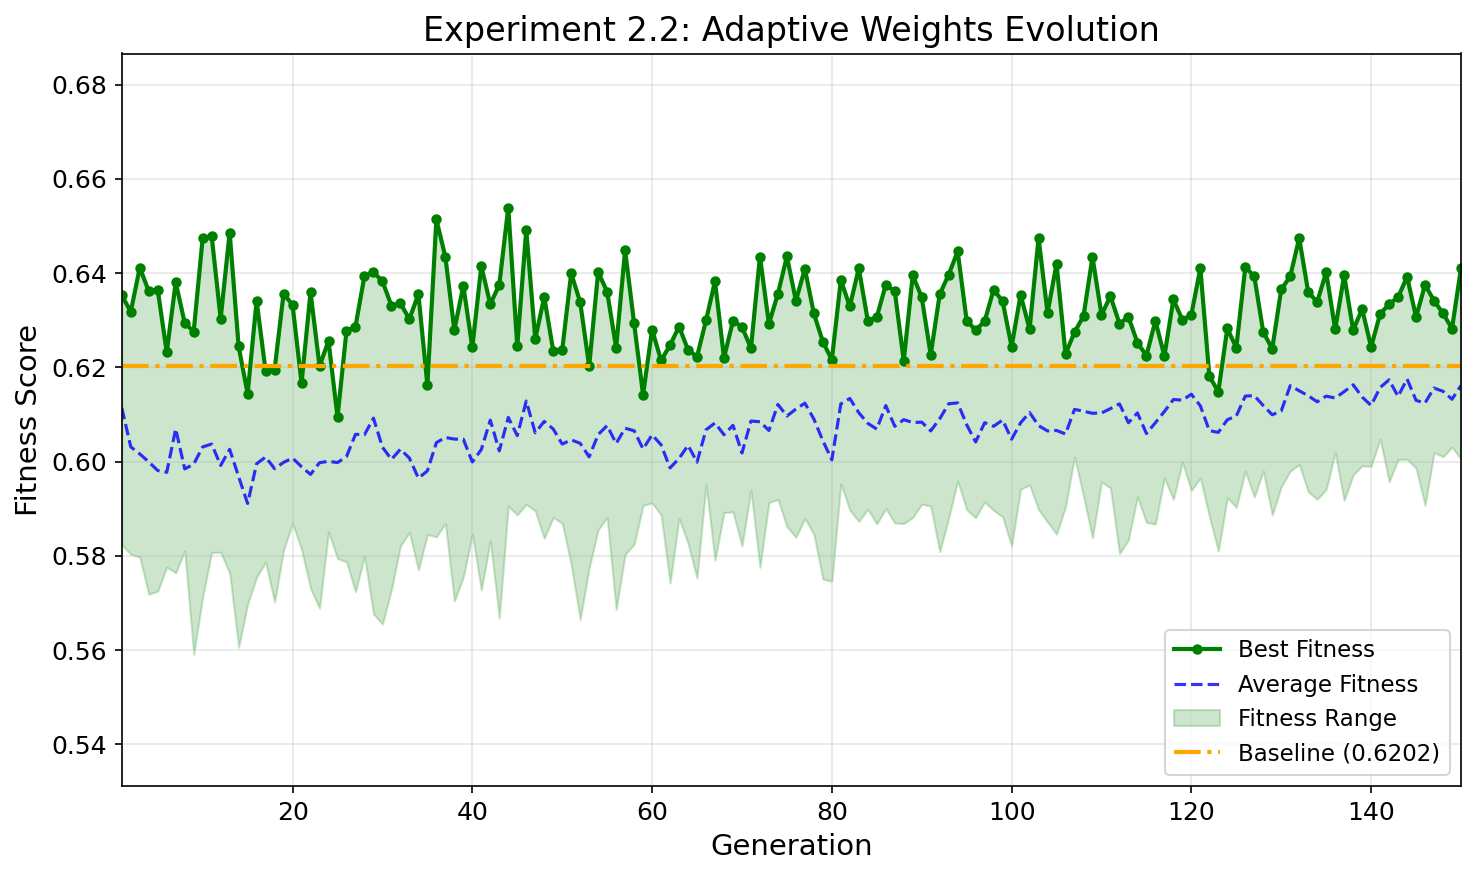

In [11]:
# Visualize adaptive experiment convergence
fig_adaptive = visualize_results(
    adaptive_history, 
    baseline_score,
    title="Experiment 2.2: Adaptive Weights Evolution"
)
fig_adaptive.savefig(OUTPUT_DIR / "exp2_2_convergence.png")
plt.show()

## Cell 9: Comparison & Statistical Analysis

COMPARISON: STATIC vs ADAPTIVE WEIGHTS


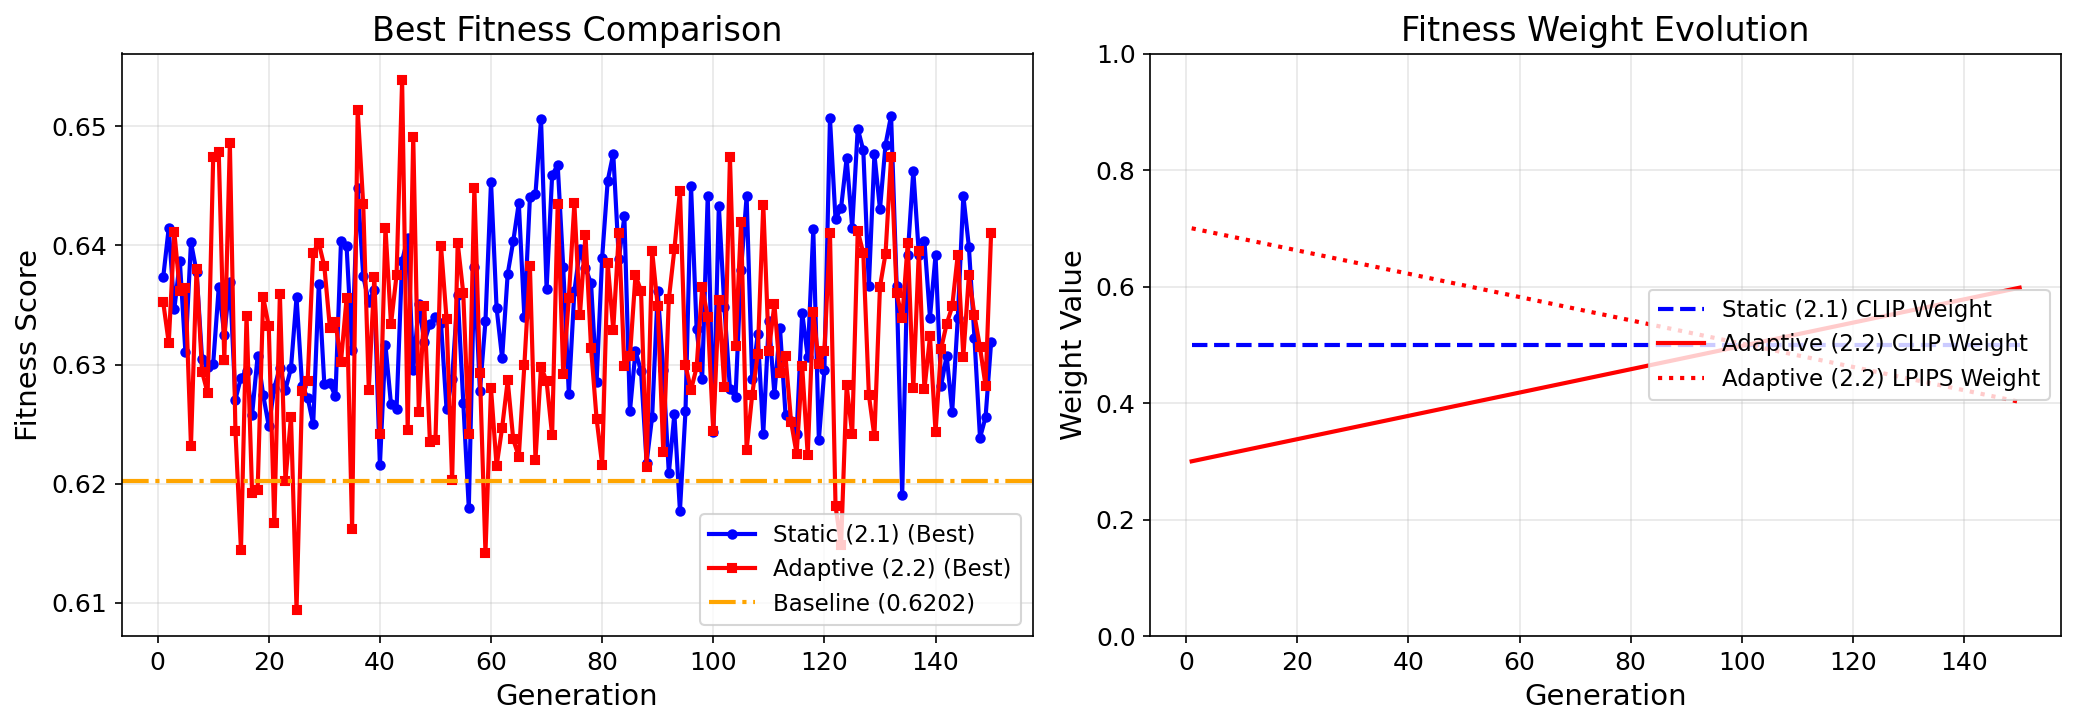


------------------------------------------------------------
STATISTICAL ANALYSIS
------------------------------------------------------------

Independent t-test:
  t-statistic: -1.6471
  p-value: 0.1078
  Significant (p < 0.05): No

Mann-Whitney U test:
  U-statistic: 149.0000
  p-value: 0.1719
  Significant (p < 0.05): No

------------------------------------------------------------
DESCRIPTIVE STATISTICS
------------------------------------------------------------

Baseline:
  Fitness: 0.6202

Static Weights (Exp 2.1):
  Mean:   0.6105
  Std:    0.0109
  Min:    0.5924
  Max:    0.6319
  Median: 0.6075

Adaptive Weights (Exp 2.2):
  Mean:   0.6161
  Std:    0.0104
  Min:    0.6005
  Max:    0.6410
  Median: 0.6170

Effect Size (Cohen's d): 0.5344
  Interpretation: medium effect


In [12]:
print("=" * 60)
print("COMPARISON: STATIC vs ADAPTIVE WEIGHTS")
print("=" * 60)

# Side-by-side convergence comparison
fig_comparison = compare_experiments(
    static_history,
    adaptive_history,
    baseline_score,
    exp1_name="Static (2.1)",
    exp2_name="Adaptive (2.2)"
)
fig_comparison.savefig(OUTPUT_DIR / "comparison_plot.png")
plt.show()

# Extract final fitness values for statistical comparison
static_final = [g.fitness for g in static_population]
adaptive_final = [g.fitness for g in adaptive_population]

# Statistical tests
print("\n" + "-" * 60)
print("STATISTICAL ANALYSIS")
print("-" * 60)

# Independent samples t-test
t_stat, p_value = stats.ttest_ind(static_final, adaptive_final)
print(f"\nIndependent t-test:")
print(f"  t-statistic: {t_stat:.4f}")
print(f"  p-value: {p_value:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if p_value < 0.05 else 'No'}")

# Mann-Whitney U test (non-parametric alternative)
u_stat, u_pvalue = stats.mannwhitneyu(static_final, adaptive_final, alternative='two-sided')
print(f"\nMann-Whitney U test:")
print(f"  U-statistic: {u_stat:.4f}")
print(f"  p-value: {u_pvalue:.4f}")
print(f"  Significant (p < 0.05): {'Yes' if u_pvalue < 0.05 else 'No'}")

# Descriptive statistics
print("\n" + "-" * 60)
print("DESCRIPTIVE STATISTICS")
print("-" * 60)

print(f"\nBaseline:")
print(f"  Fitness: {baseline_score:.4f}")

print(f"\nStatic Weights (Exp 2.1):")
print(f"  Mean:   {np.mean(static_final):.4f}")
print(f"  Std:    {np.std(static_final):.4f}")
print(f"  Min:    {np.min(static_final):.4f}")
print(f"  Max:    {np.max(static_final):.4f}")
print(f"  Median: {np.median(static_final):.4f}")

print(f"\nAdaptive Weights (Exp 2.2):")
print(f"  Mean:   {np.mean(adaptive_final):.4f}")
print(f"  Std:    {np.std(adaptive_final):.4f}")
print(f"  Min:    {np.min(adaptive_final):.4f}")
print(f"  Max:    {np.max(adaptive_final):.4f}")
print(f"  Median: {np.median(adaptive_final):.4f}")

# Effect size (Cohen's d)
pooled_std = np.sqrt(((len(static_final) - 1) * np.var(static_final) + 
                      (len(adaptive_final) - 1) * np.var(adaptive_final)) / 
                     (len(static_final) + len(adaptive_final) - 2))
cohens_d = (np.mean(adaptive_final) - np.mean(static_final)) / pooled_std if pooled_std > 0 else 0

print(f"\nEffect Size (Cohen's d): {cohens_d:.4f}")
if abs(cohens_d) < 0.2:
    effect_interpretation = "negligible"
elif abs(cohens_d) < 0.5:
    effect_interpretation = "small"
elif abs(cohens_d) < 0.8:
    effect_interpretation = "medium"
else:
    effect_interpretation = "large"
print(f"  Interpretation: {effect_interpretation} effect")

/var/folders/p7/7kcv3ngd7q18v8lpks6vq25r0000gn/T/ipykernel_59128/3238204588.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 2.1)', 'Adaptive Weights\n(Exp 2.2)'],


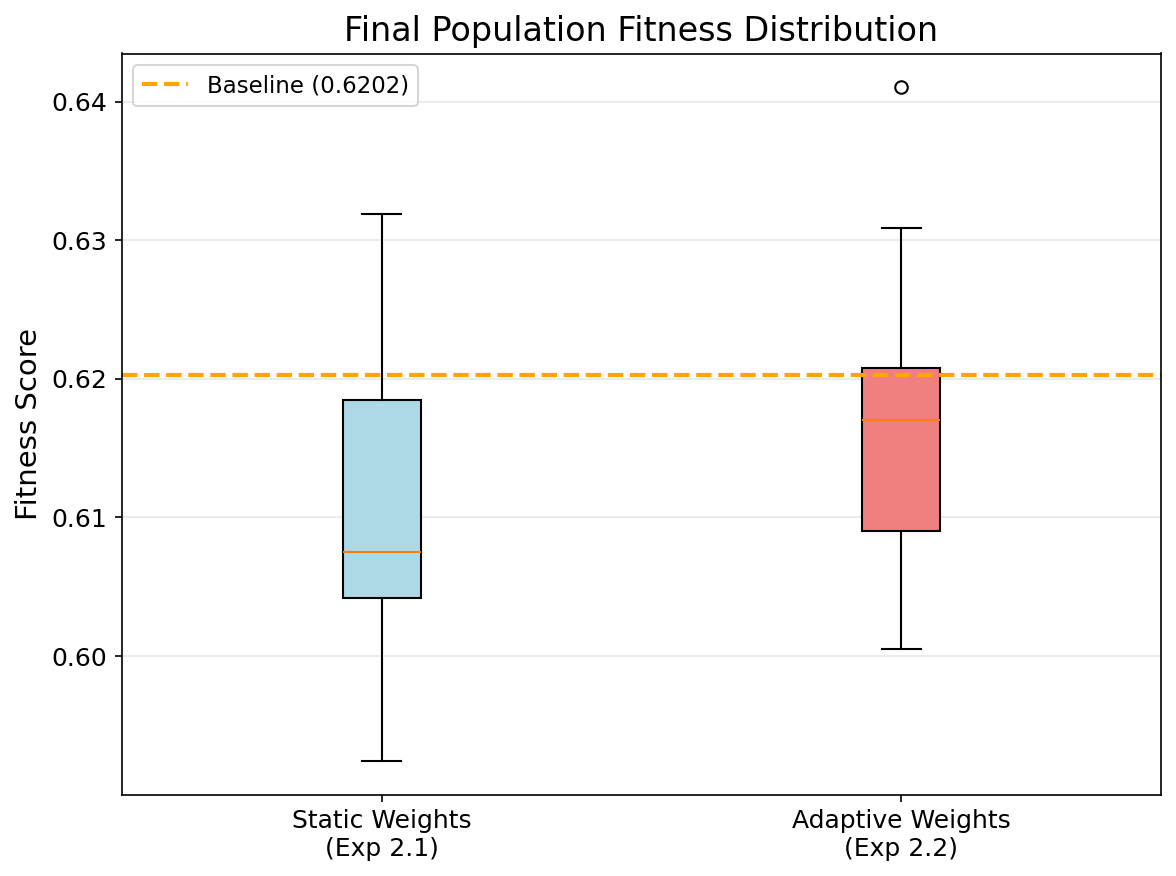

In [13]:
# Box plot comparison
fig, ax = plt.subplots(figsize=(8, 6))

box_data = [static_final, adaptive_final]
bp = ax.boxplot(box_data, labels=['Static Weights\n(Exp 2.1)', 'Adaptive Weights\n(Exp 2.2)'],
                patch_artist=True)

# Color the boxes
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')

# Add baseline line
ax.axhline(y=baseline_score, color='orange', linestyle='--', 
           linewidth=2, label=f'Baseline ({baseline_score:.4f})')

ax.set_ylabel('Fitness Score')
ax.set_title('Final Population Fitness Distribution')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / "boxplot_comparison.png")
plt.show()

## Cell 10: Visual Comparison

In [14]:
print("Generating final comparison images...")
print("This may take a moment...\n")

# Generate final images with consistent seed for fair comparison
COMPARISON_SEED = 12345

# Baseline image (regenerate with comparison seed)
print("Generating baseline image...")
baseline_final_image, baseline_final_score = generate_final_image(
    factory.create_empty(USER_SUBJECT), 
    seed=COMPARISON_SEED
)

# Best static image
print("Generating best static weights image...")
static_final_image, static_final_score = generate_final_image(
    best_static_genome, 
    seed=COMPARISON_SEED
)

# Best adaptive image
print("Generating best adaptive weights image...")
adaptive_final_image, adaptive_final_score = generate_final_image(
    best_adaptive_genome, 
    seed=COMPARISON_SEED
)

print("Image generation complete.")

Generating final comparison images...
This may take a moment...

Generating baseline image...
Generating best static weights image...
Generating best adaptive weights image...
Image generation complete.


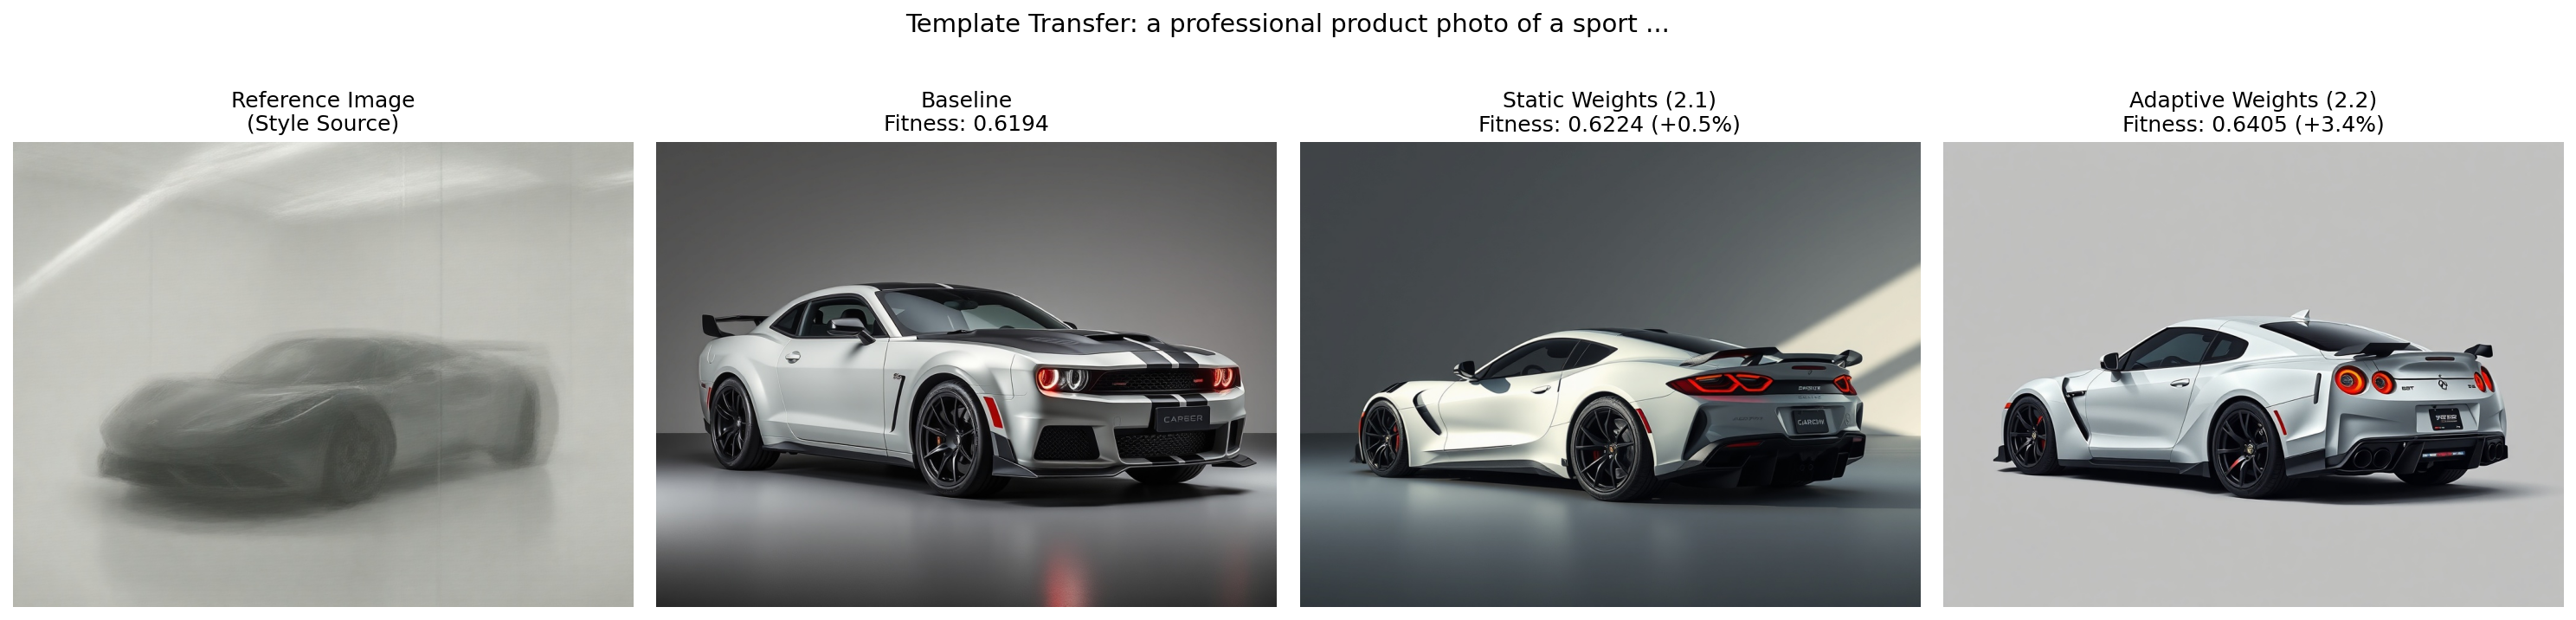


Images saved to output directory.


In [15]:
# Create comprehensive visual comparison: Reference + Baseline + Static + Adaptive
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# Reference
axes[0].imshow(reference_image)
axes[0].set_title("Reference Image\n(Style Source)", fontsize=12)
axes[0].axis('off')

# Baseline
axes[1].imshow(baseline_final_image)
axes[1].set_title(f"Baseline\nFitness: {baseline_final_score:.4f}", fontsize=12)
axes[1].axis('off')

# Static best
axes[2].imshow(static_final_image)
improvement_static = (static_final_score - baseline_final_score) / baseline_final_score * 100
axes[2].set_title(f"Static Weights (2.1)\nFitness: {static_final_score:.4f} (+{improvement_static:.1f}%)", fontsize=12)
axes[2].axis('off')

# Adaptive best
axes[3].imshow(adaptive_final_image)
improvement_adaptive = (adaptive_final_score - baseline_final_score) / baseline_final_score * 100
axes[3].set_title(f"Adaptive Weights (2.2)\nFitness: {adaptive_final_score:.4f} (+{improvement_adaptive:.1f}%)", fontsize=12)
axes[3].axis('off')

plt.suptitle(f"Template Transfer: {USER_SUBJECT[:40]}...", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "visual_comparison.png", bbox_inches='tight')
plt.show()

# Save individual images
baseline_final_image.save(OUTPUT_DIR / "final_baseline.jpg")
static_final_image.save(OUTPUT_DIR / "final_static_best.jpg")
adaptive_final_image.save(OUTPUT_DIR / "final_adaptive_best.jpg")

print("\nImages saved to output directory.")

In [16]:
# Print evolved prompts for comparison
print("=" * 60)
print("EVOLVED PROMPTS COMPARISON")
print("=" * 60)

print(f"\nBASELINE PROMPT:")
print(f"  Positive: {USER_SUBJECT}")
print(f"  Negative: (none)")

print(f"\nSTATIC WEIGHTS BEST PROMPT:")
print(f"  Full: {best_static_genome.to_prompt()}")
print(f"  Negative: {best_static_genome.get_negative_prompt()}")
print(f"  Blocks:")
print(f"    Composition: {best_static_genome.composition}")
print(f"    Lighting: {best_static_genome.lighting}")
print(f"    Style: {best_static_genome.style}")
print(f"    Quality: {best_static_genome.quality}")

print(f"\nADAPTIVE WEIGHTS BEST PROMPT:")
print(f"  Full: {best_adaptive_genome.to_prompt()}")
print(f"  Negative: {best_adaptive_genome.get_negative_prompt()}")
print(f"  Blocks:")
print(f"    Composition: {best_adaptive_genome.composition}")
print(f"    Lighting: {best_adaptive_genome.lighting}")
print(f"    Style: {best_adaptive_genome.style}")
print(f"    Quality: {best_adaptive_genome.quality}")

EVOLVED PROMPTS COMPARISON

BASELINE PROMPT:
  Positive: a professional product photo of a sport car
  Negative: (none)

STATIC WEIGHTS BEST PROMPT:
  Full: a professional product photo of a sport car, photorealistic, sharp, diagonal composition, low-key lighting, neutral light, softbox, octabox, direct sunlight, polaroid, installation art, geometric abstraction, architectural photography, game art, digital art, digital asset management, artifact removal, cloud computing
  Negative: copyright infringement, social unrest, corruption
  Blocks:
    Composition: ['photorealistic', 'sharp', 'diagonal composition']
    Lighting: ['low-key lighting', 'neutral light', 'softbox', 'octabox', 'direct sunlight']
    Style: ['polaroid', 'installation art', 'geometric abstraction', 'architectural photography', 'game art']
    Quality: ['digital art', 'digital asset management', 'artifact removal', 'cloud computing']

ADAPTIVE WEIGHTS BEST PROMPT:
  Full: a professional product photo of a sport car, 

## Cell 11: Return All Results Array

In [17]:
# =============================================================================
# ALL RESULTS ARRAY
# =============================================================================
# This cell returns the complete results array with all generated images,
# prompts, and fitness scores.

print("=" * 60)
print("ALL RESULTS ARRAY")
print("=" * 60)

print(f"\nTotal entries in ALL_RESULTS: {len(ALL_RESULTS)}")

# Save ALL_RESULTS to JSON file
all_results_path = OUTPUT_DIR / "all_results_array.json"
save_json(ALL_RESULTS, str(all_results_path))
print(f"All results saved to: {all_results_path}")

# Display summary statistics
exp2_1_results = [r for r in ALL_RESULTS if r['experiment'] == 'exp2_1_static']
exp2_2_results = [r for r in ALL_RESULTS if r['experiment'] == 'exp2_2_adaptive']

print(f"\nExperiment 2.1 (Static): {len(exp2_1_results)} images")
print(f"Experiment 2.2 (Adaptive): {len(exp2_2_results)} images")

# Get top 10 results by fitness across all experiments
sorted_results = sorted(ALL_RESULTS, key=lambda x: x['fitness'], reverse=True)
print("\n" + "-" * 60)
print("TOP 10 RESULTS BY FITNESS:")
print("-" * 60)
for i, result in enumerate(sorted_results[:10], 1):
    print(f"\n{i}. Fitness: {result['fitness']:.4f}")
    print(f"   Experiment: {result['experiment']}")
    print(f"   Generation: {result['generation']}")
    print(f"   Prompt: {result['prompt'][:80]}...")
    print(f"   Negative: {result['negative_prompt'][:50] if result['negative_prompt'] else 'None'}...")
    print(f"   Image: {result['image_path'].split('/')[-1] if result['image_path'] else 'N/A'}")

# Display the array structure
print("\n" + "-" * 60)
print("ARRAY STRUCTURE (sample entry):")
print("-" * 60)
if ALL_RESULTS:
    sample = ALL_RESULTS[0]
    for key, value in sample.items():
        if isinstance(value, dict):
            print(f"  {key}:")
            for k, v in value.items():
                print(f"    {k}: {v[:3]}..." if isinstance(v, list) and len(v) > 3 else f"    {k}: {v}")
        elif isinstance(value, list):
            print(f"  {key}: {value[:3]}..." if len(value) > 3 else f"  {key}: {value}")
        elif isinstance(value, str) and len(value) > 50:
            print(f"  {key}: {value[:50]}...")
        else:
            print(f"  {key}: {value}")

print("\n" + "=" * 60)
print("ACCESS ALL_RESULTS VARIABLE FOR FULL DATA")
print("=" * 60)

ALL RESULTS ARRAY

Total entries in ALL_RESULTS: 6000
All results saved to: ../data/results/experiment_2/all_results_array.json

Experiment 2.1 (Static): 3000 images
Experiment 2.2 (Adaptive): 3000 images

------------------------------------------------------------
TOP 10 RESULTS BY FITNESS:
------------------------------------------------------------

1. Fitness: 0.6539
   Experiment: exp2_2_adaptive
   Generation: 44
   Prompt: a professional product photo of a sport car, classic, carefully crafted composit...
   Negative: duplicate, noisy...
   Image: gen044_idx00_fit0.6539.jpg

2. Fitness: 0.6514
   Experiment: exp2_2_adaptive
   Generation: 36
   Prompt: a professional product photo of a sport car, negative space, stylized, extreme c...
   Negative: bad quality, cybercrime, hostage taking, technolog...
   Image: gen036_idx00_fit0.6514.jpg

3. Fitness: 0.6509
   Experiment: exp2_1_static
   Generation: 132
   Prompt: a professional product photo of a sport car, artificial light, p

In [18]:
# Return ALL_RESULTS array for programmatic access
# This cell outputs the complete array containing all experimental data

ALL_RESULTS

[{'experiment': 'exp2_1_static',
  'generation': 1,
  'individual_index': 0,
  'prompt': 'a professional product photo of a sport car, wide angle, centered, studio shot, soft diffused light, uniform lighting, minimal shadows, photorealistic, clean, modern, 8k, detailed, high resolution',
  'negative_prompt': 'blurry, distorted, grainy',
  'blocks': {'composition': ['wide angle', 'centered', 'studio shot'],
   'lighting': ['soft diffused light', 'uniform lighting', 'minimal shadows'],
   'style': ['photorealistic', 'clean', 'modern'],
   'quality': ['8k', 'detailed', 'high resolution'],
   'negative': ['blurry', 'distorted', 'grainy']},
  'fitness': 0.6301720181311044,
  'image_path': '../data/results/experiment_2/exp2_1_static/all_images/gen001_idx00_fit0.6302.jpg',
  'clip_weight': 0.5,
  'lpips_weight': 0.5},
 {'experiment': 'exp2_1_static',
  'generation': 1,
  'individual_index': 1,
  'prompt': 'a professional product photo of a sport car, front view, eye-level, studio backdrop, so